# G2-Net Gravitational Wave Detection (Full Notebook)

In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("/content/utils.rar", outdir="./")

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!gcloud config set project g2-tfrecords
!gsutil ls

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

gs://g2-gravitational-waves-tfrecords_bucket/


In [ ]:
!pip install tensorflow_addons
!pip install tensorflow_io

In [ ]:
!pip install gwpy

In [2]:
!pip install -q vit-keras

In [3]:
!pip install efficientnet tensorflow_addons > /dev/null

## Importing Libraries and Dataset

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.1, rc={
    'figure.figsize': (15, 10),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})
import plotly.express as px

import cv2
import json
import random
import collections

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import mixed_precision
from vit_keras import vit, utils, visualize


from typing import Optional, Tuple
import warnings
from scipy.signal import get_window
import re
import os
import logging
tf.get_logger().setLevel(logging.WARNING)
# from gwpy.timeseries import TimeSeries
# from gwpy.plot import Plot

import librosa
import librosa.display
import joblib
from tqdm.auto import tqdm
from skimage.transform import resize

# import gwpy
from scipy import signal 

In [8]:
RAW_TRAINING_GCS_PATTERN = 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/*.tfrecords'
RAW_TRAINING_FILENAMES = tf.io.gfile.glob(RAW_TRAINING_GCS_PATTERN)
all_files = []
all_files.append(RAW_TRAINING_FILENAMES[10])
for i in RAW_TRAINING_FILENAMES[12:]:
  all_files.append(i)
for i in RAW_TRAINING_FILENAMES[0:10]:
  all_files.append(i)
all_files.append(RAW_TRAINING_FILENAMES[11])
RAW_TRAINING_FILENAMES = all_files
RAW_TRAINING_FILENAMES

['gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/1_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/2_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/3_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/4_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/5_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/6_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/7_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/8_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/9_20-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecor

In [9]:
IMG_TRAINING_GCS_PATTERN = 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/*.tfrecords'
IMG_TRAINING_FILENAMES = tf.io.gfile.glob(IMG_TRAINING_GCS_PATTERN)
_temp = IMG_TRAINING_FILENAMES[1:]
_temp.append(IMG_TRAINING_FILENAMES[0])
IMG_TRAINING_FILENAMES = _temp
IMG_TRAINING_FILENAMES

['gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/1_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/2_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/3_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/4_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/5_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/6_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/7_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/8_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/9_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/10_10-g2-gravitational-waves.tfrecords']

In [10]:
RAW_TESTING_GCS_PATTERN = 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/*.tfrecords'
RAW_TESTING_FILENAMES = tf.io.gfile.glob(RAW_TESTING_GCS_PATTERN)
RAW_TESTING_FILENAMES

['gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/1_9-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/2_9-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/3_9-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/4_9-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/5_9-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/6_9-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/7_9-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/8_9-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/9_9-g2-gravitational-waves.tfrecords']

In [11]:
train = pd.read_csv("/content/drive/MyDrive/training_labels.csv")
train

id  target
0       00000e74ad       1
1       00001f4945       0
2       0000661522       0
3       00007a006a       0
4       0000a38978       1
...            ...     ...
559995  ffff9a5645       1
559996  ffffab0c27       0
559997  ffffcf161a       1
559998  ffffd2c403       0
559999  fffff2180b       0

[560000 rows x 2 columns]

In [12]:
test = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")
test

id  target
0       00005bced6     0.5
1       0000806717     0.5
2       0000ef4fe1     0.5
3       00020de251     0.5
4       00024887b5     0.5
...            ...     ...
225995  ffff4125f1     0.5
225996  ffff9d32a6     0.5
225997  ffff9f4c1f     0.5
225998  ffffa19693     0.5
225999  ffffebbfe2     0.5

[226000 rows x 2 columns]

## Top Level Data Analysis

### The Distribution of the Training Data

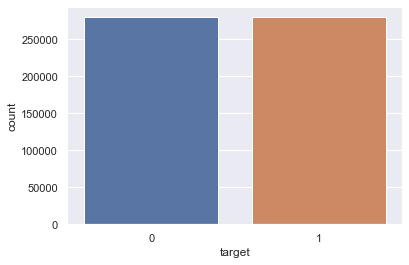

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="target", data=train)

### Functions for Data Preparation

In [ ]:
def train_get_path_from_id(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id 
    )

In [ ]:
def test_get_path_from_id(image_id: str, is_train: bool = True) -> str:
    folder = "test" if is_train else "train"
    return "{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id 
    )

In [ ]:
test['file_path'] = test['id'].apply(test_get_path_from_id)

In [ ]:
test.head()

id  target                  file_path
0  00005bced6     0.5  test/0/0/0/00005bced6.npy
1  0000806717     0.5  test/0/0/0/0000806717.npy
2  0000ef4fe1     0.5  test/0/0/0/0000ef4fe1.npy
3  00020de251     0.5  test/0/0/0/00020de251.npy
4  00024887b5     0.5  test/0/0/0/00024887b5.npy

In [ ]:
train['file_path'] = train['id'].apply(train_get_path_from_id)

In [ ]:
train.head()

id  target                   file_path
0  00000e74ad       1  train/0/0/0/00000e74ad.npy
1  00001f4945       0  train/0/0/0/00001f4945.npy
2  0000661522       0  train/0/0/0/0000661522.npy
3  00007a006a       0  train/0/0/0/00007a006a.npy
4  0000a38978       1  train/0/0/0/0000a38978.npy

In [ ]:
raw_array_dataset = tf.data.TFRecordDataset(RAW_TRAINING_FILENAMES[0])

image_feature_description = {
    'array_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

### Graphing the Data in Time Series

<Figure size 1080x720 with 0 Axes>

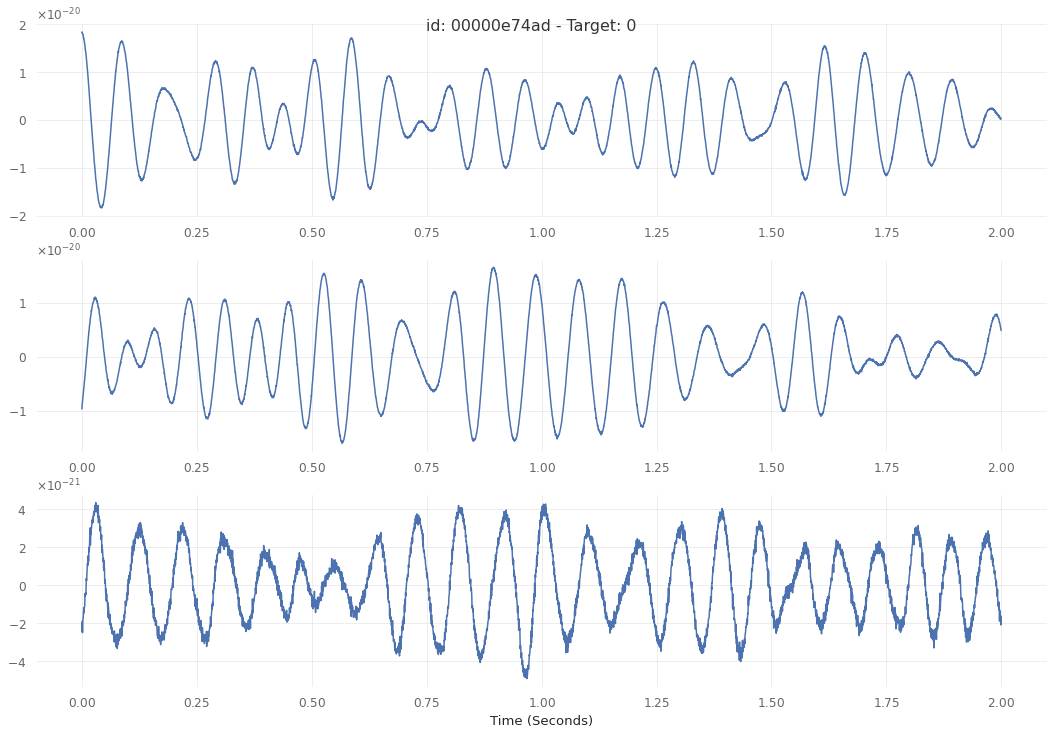

<Figure size 1080x720 with 0 Axes>

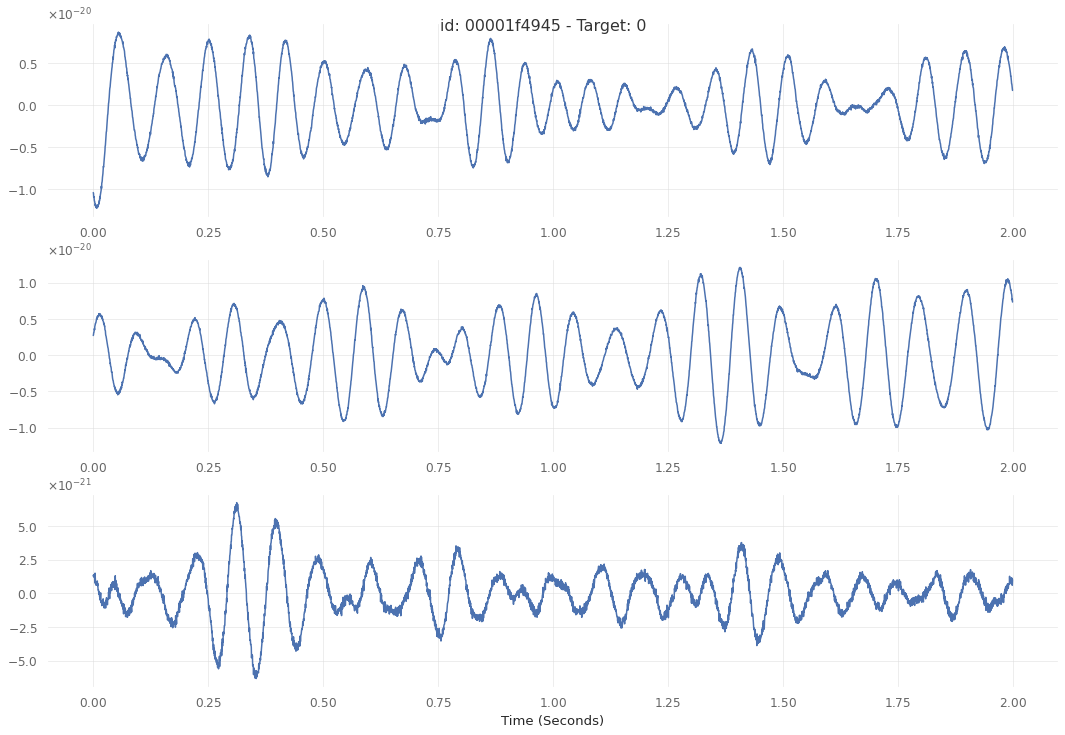

<Figure size 1080x720 with 0 Axes>

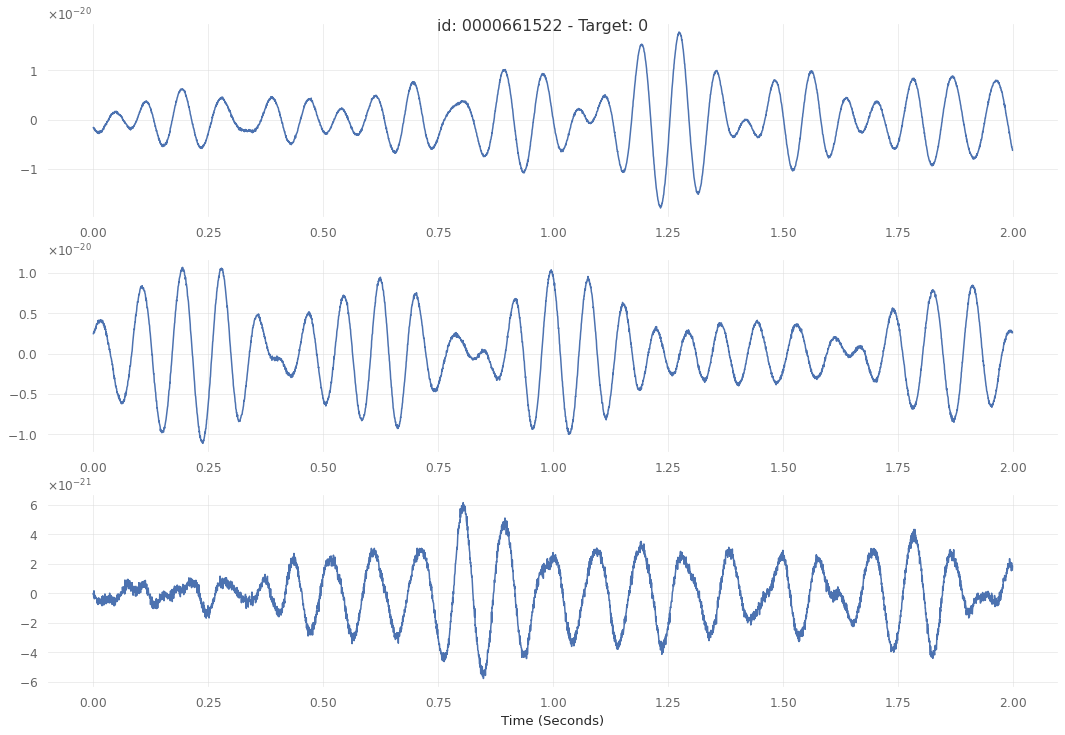

In [ ]:
for i in range(3):
  parsed_array_dataset = raw_array_dataset.map(_parse_image_function)
  array_idx = i
  for array_feature in parsed_array_dataset.take(array_idx+1):
      wave = tf.reshape(tf.io.decode_raw(array_feature['array_raw'], tf.float64), (3, 4096))
      array_label = array_feature['label']

  sample_rate = 2048
  wave_length = len(wave[0])
  timeseries_in_seconds = wave_length/sample_rate
  time_series_steps= 1/(wave_length/timeseries_in_seconds)

  plt.figure(figsize=(15,10))
  fig, ax = plt.subplots(3)
  fig.tight_layout()
  _id = train.iloc[array_idx]['id']

  fig.suptitle(f'id: {_id} - Target: {array_label}')
  _l1 = sns.lineplot(x=np.arange(0,timeseries_in_seconds, time_series_steps), y=wave[0], ax=ax[0])
  _l2 = sns.lineplot(x=np.arange(0,timeseries_in_seconds, time_series_steps), y=wave[1], ax=ax[1])
  _l3 = sns.lineplot(x=np.arange(0,timeseries_in_seconds, time_series_steps), y=wave[2], ax=ax[2])
  plt.xlabel('Time (Seconds)')

## Traditional Signal Processing Techniques

### Graphing Time Series Data onto a Frequency Spectrum

(10, 1024)

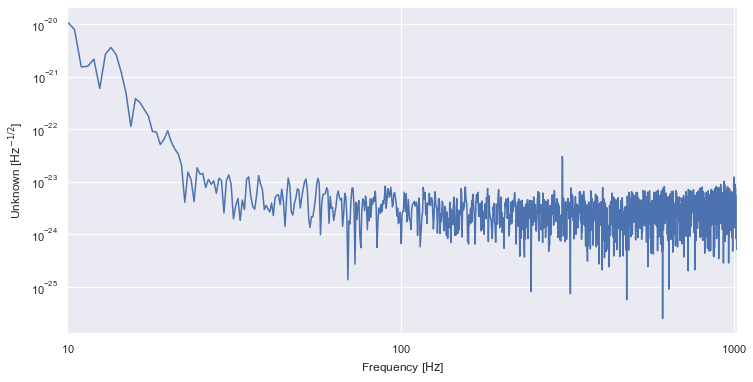

In [ ]:
fig = d1.asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
# plt.ylim(1e-25, 1e-20);

### Mel Spectrogram

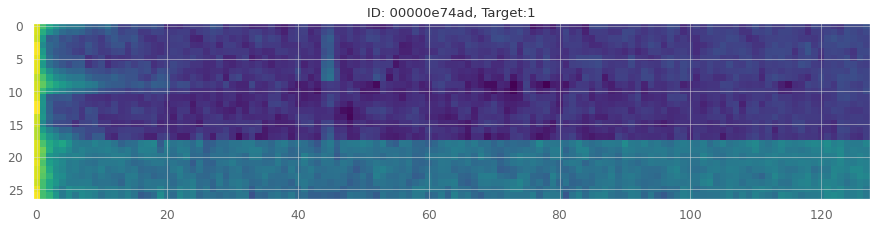

In [ ]:
for i in range(1):
  parsed_array_dataset = raw_array_dataset.map(_parse_image_function)
  for array_feature in parsed_array_dataset.take(i+1):
      wave = tf.reshape(tf.io.decode_raw(array_feature['array_raw'], tf.float64), (3, 4096))
      array_label = array_feature['label']


      spectro_array = []
      for k in range(3):
        _label = train.iloc[i]['target']
        _id = train.iloc[i]['id']
        S = librosa.feature.melspectrogram(wave[k].numpy() / max(wave[k].numpy()), sr=sample_rate*2, n_mels=128, fmin=20, fmax=2048)
        S = librosa.power_to_db(S)
        S = S.transpose((1,0))
        spectro_array.append(S)
      image = np.vstack(spectro_array)
      plt.imshow(image, cmap='viridis')
      plt.title(f'ID: {_id}, Target:{_label}')

### Short-time Fourier Transform Spectrogram

<Figure size 1080x720 with 0 Axes>

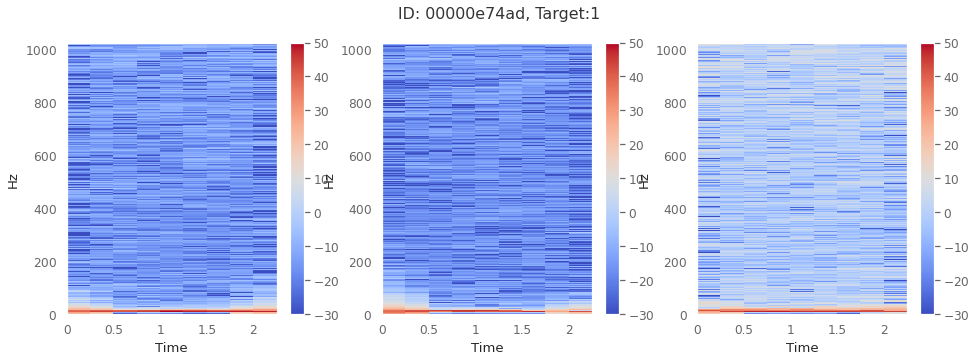

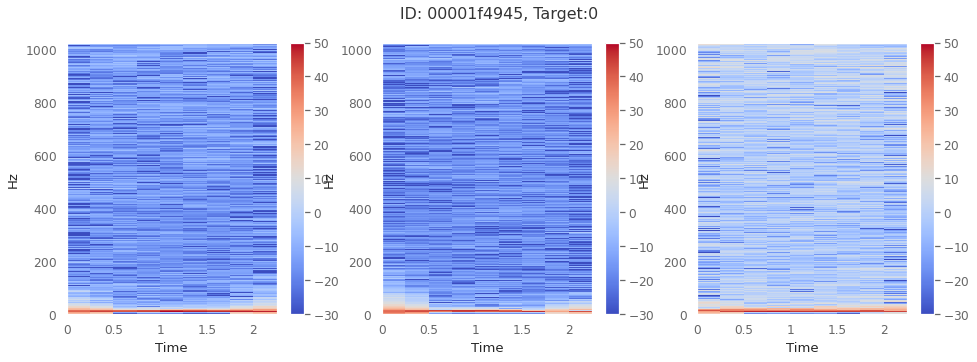

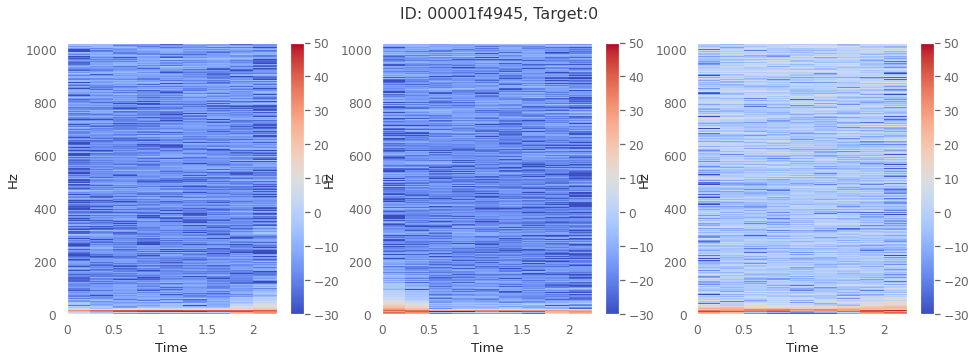

In [ ]:
plt.tight_layout()
for i in range(2):
  parsed_array_dataset = raw_array_dataset.map(_parse_image_function)
  for array_feature in parsed_array_dataset.take(i+1):
      wave = tf.reshape(tf.io.decode_raw(array_feature['array_raw'], tf.float64), (3, 4096))
      array_label = array_feature['label']
      
      
      plt.figure(figsize=(16, 5))
      
      for k in range(3):
          plt.subplot(i+1, 3, k + 1)
          # STFT of normalised wave
          wave_X = librosa.stft(wave[k].numpy() / wave[k].numpy().max())
          Xdb = librosa.amplitude_to_db(abs(wave_X))

          plt.subplot(1, 3, k + 1)
          librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=-30, vmax=50) 
          plt.colorbar()
          _id = train.iloc[i]['id']
          _label = train.iloc[i]['target']
      plt.suptitle(f'ID: {_id}, Target:{_label}')

#### Power Spectral Density

In [ ]:
sample_rate = 2048
total_samples = sample_rate*2
dt = 1/total_samples

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



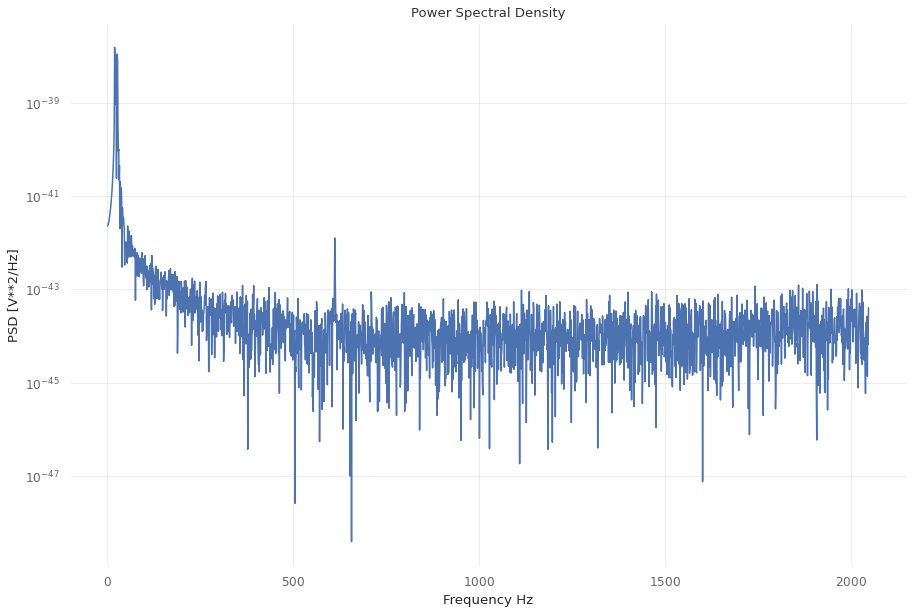

In [ ]:
fhat = np.fft.fft(wave[0,:], total_samples)
PSD = fhat * np.conj(fhat) / total_samples
freq = 1/(dt*total_samples) * np.arange(total_samples)


L = np.arange(1, np.floor(total_samples/2), dtype="int")
plt.plot(freq[L],PSD[L])
plt.xlabel("Frequency Hz");
plt.ylabel('PSD [V**2/Hz]')
plt.title("Power Spectral Density");
plt.yscale("log")

#### Power Spectrum

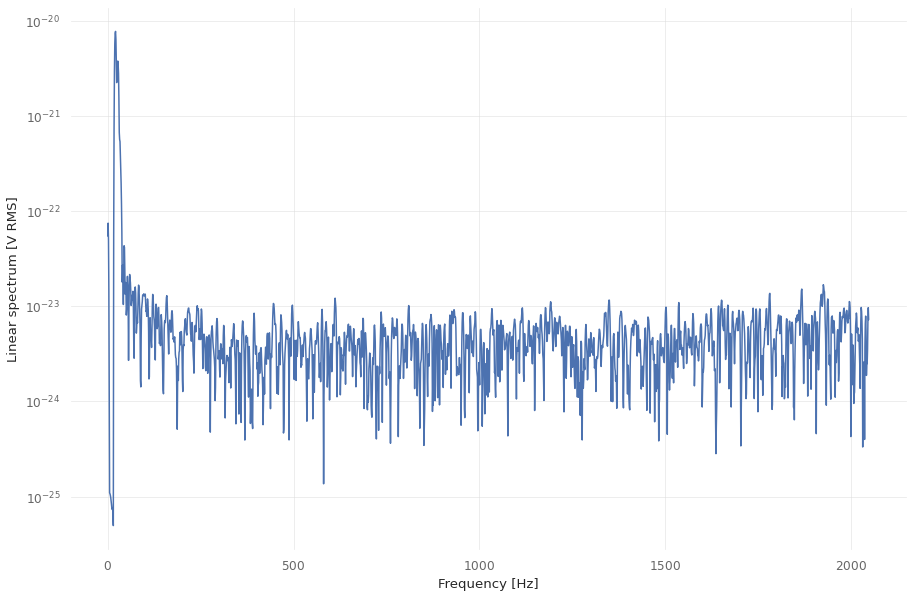

In [ ]:
f, Pxx_spec = signal.periodogram(wave[0], sample_rate*2, 'flattop', scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
# plt.gca().invert_yaxis()
plt.show()

### Applying a Window Function

https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.tukey.html

In [ ]:
hp_window = 1
hp_tukey_alpha = 0.125
fband = [35.0, 200.0]

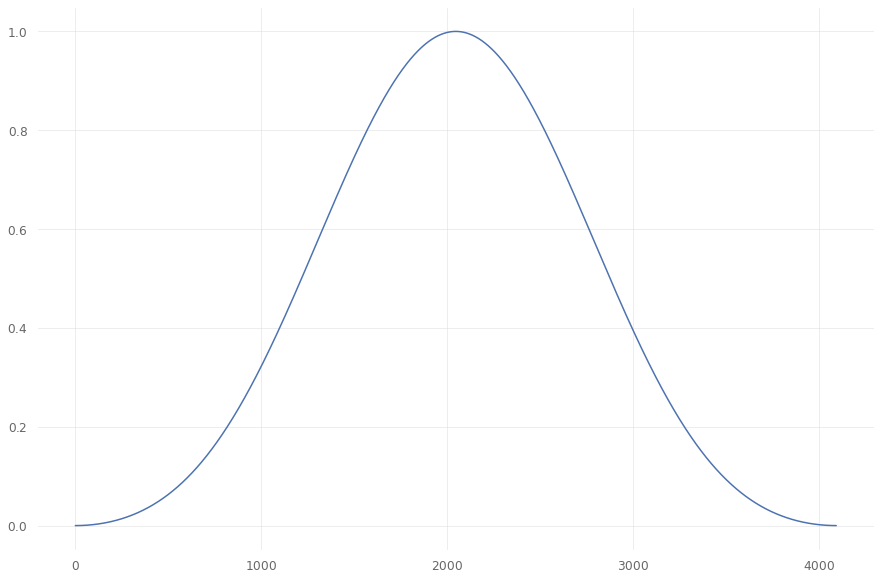

In [ ]:
blackman_window = signal.blackman(int(total_samples*hp_window))
plt.plot(blackman_window)

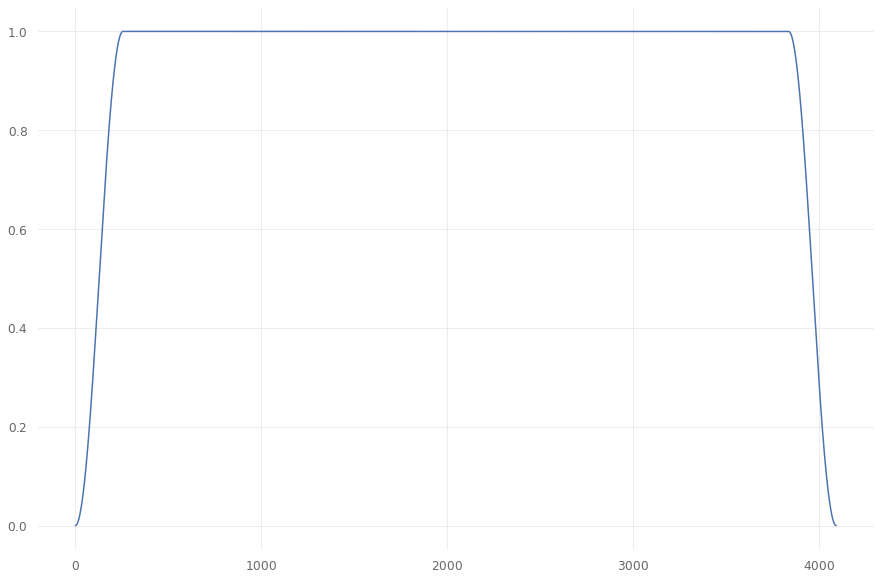

In [ ]:
tukey_window = signal.tukey(total_samples*hp_window, hp_tukey_alpha)
plt.plot(tukey_window)

Text(0.5, 1.0, 'Wave with Tukey Window Applied')

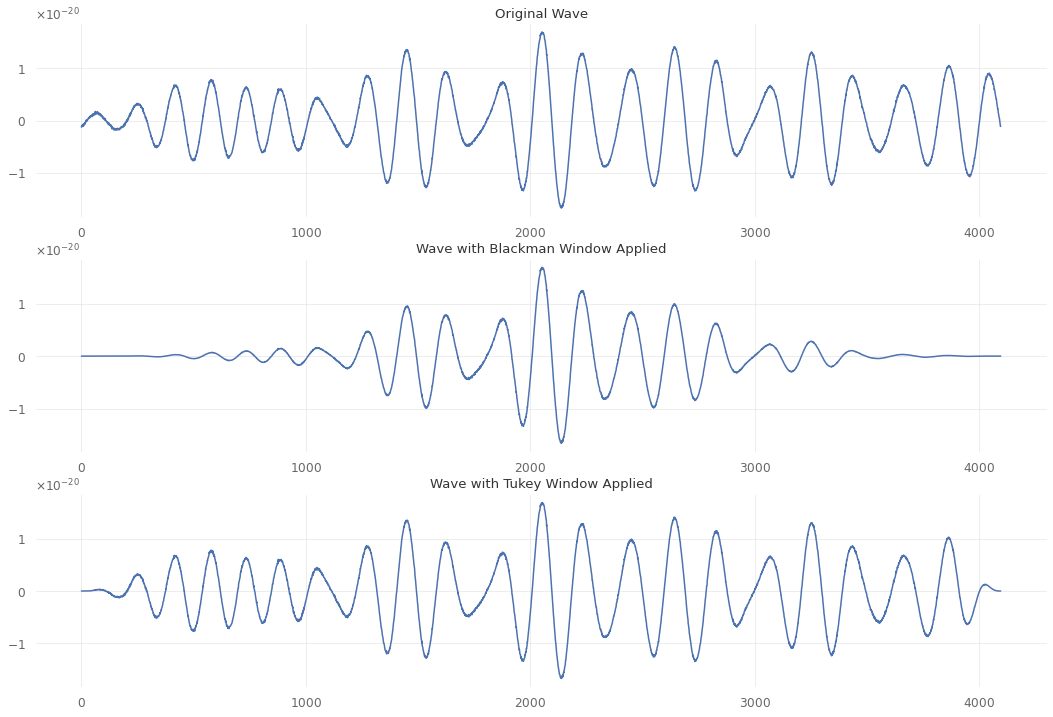

In [ ]:
fig, ax = plt.subplots(3, 1)
plt.tight_layout()
ax[0].plot(wave[0])
ax[0].set_title('Original Wave')
ax[1].plot(wave[0]*blackman_window)
ax[1].set_title('Wave with Blackman Window Applied')
ax[2].plot(wave[0]*tukey_window)
ax[2].set_title('Wave with Tukey Window Applied')

In [ ]:
w_strain = w_strain*tukey_window

### Whitening and Bandpassing the Signal (35Hz to 350Hz)

https://gwpy.github.io/docs/stable/examples/timeseries/whiten/?highlight=whiten

In [ ]:
!pip install gwpy

In [100]:
from gwpy.timeseries import TimeSeries

In [98]:
def preprocess(d1, d2, d3, bandpass=False, lf=35, hf=350):
    white_d1 = d1.whiten(window=("tukey",0.2))
    white_d2 = d2.whiten(window=("tukey",0.2))
    white_d3 = d3.whiten(window=("tukey",0.2))
    if bandpass: 
        bp_d1 = white_d1.bandpass(lf, hf) 
        bp_d2 = white_d2.bandpass(lf, hf)
        bp_d3 = white_d3.bandpass(lf, hf)
        return bp_d1, bp_d2, bp_d3
    else: 
        return white_d1, white_d2, white_d3

In [99]:
def whiten(strain, samples_total, dt):
    
    fhat = np.fft.fft(strain, samples_total)
    PSD = fhat * np.conj(fhat) / samples_total
    freq = 1/(dt*samples_total) * np.arange(samples_total)

    interp_psd = interp1d(freq, PSD, "nearest")
    
    w_fhat = fhat/np.sqrt(interp_psd(freq))
    w_strain = np.fft.ifft(w_fhat)
    return w_strain, interp_psd(freq)

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
res_wave = wave[0]
res_wave = res_wave*tukey_window

In [ ]:
w_strain, ip = whiten(res_wave, total_samples, dt)

In [ ]:
d1 = TimeSeries(wave.numpy()[0])
d2 = TimeSeries(wave.numpy()[1])
d3 = TimeSeries(wave.numpy()[2])
whitened_d1, whitened_d2, whitened_d3 = preprocess(d1,d2,d3)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



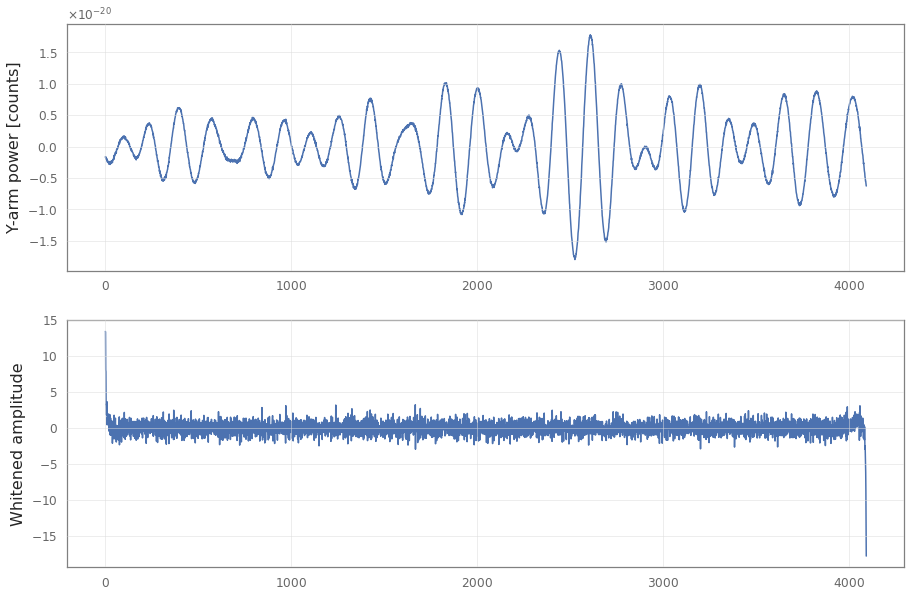

In [ ]:
white = d1.whiten(4, 2)
from gwpy.plot import Plot
plot = Plot(wave[0], w_strain, separate=True, sharex=True)
plot.axes[0].set_ylabel('Y-arm power [counts]', fontsize=16)
plot.axes[1].set_ylabel('Whitened amplitude', fontsize=16)
plot.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



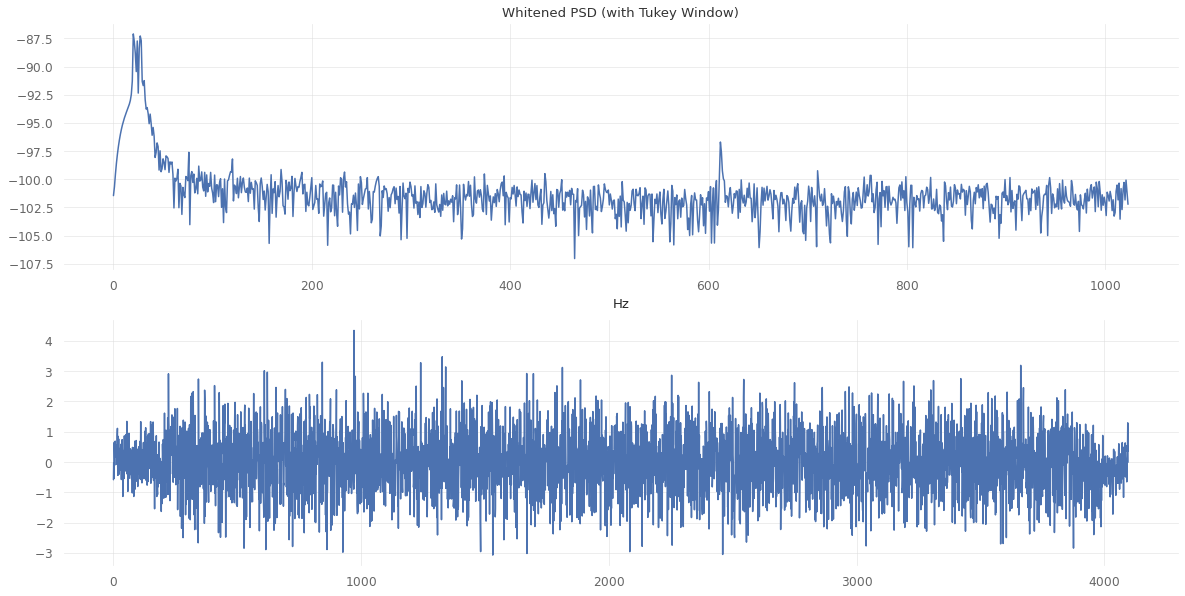

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(np.log(ip[0:1024]), '-')
ax[0].set_title("Whitened PSD (with Tukey Window)")
ax[0].set_xlabel("Hz")
ax[1].plot(w_strain, '-')

### Bandpassing

In [ ]:
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

In [ ]:
def bandpass(wave, range, sf):
    _b, _a = butter(4, [range[0]*2./sf, range[1]*2./sf], btype='band')
    norm = np.sqrt((range[1]-range[0])/(sf/2))
    wave_bp = filtfilt(_b, _a, wave) / norm
    return wave_bp

In [ ]:
fband = [35.0, 200.0]

In [ ]:
bandpassed_strain = bandpass(w_strain, fband, total_samples)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 1.0, 'Final Signal with Bandpass Filtering')

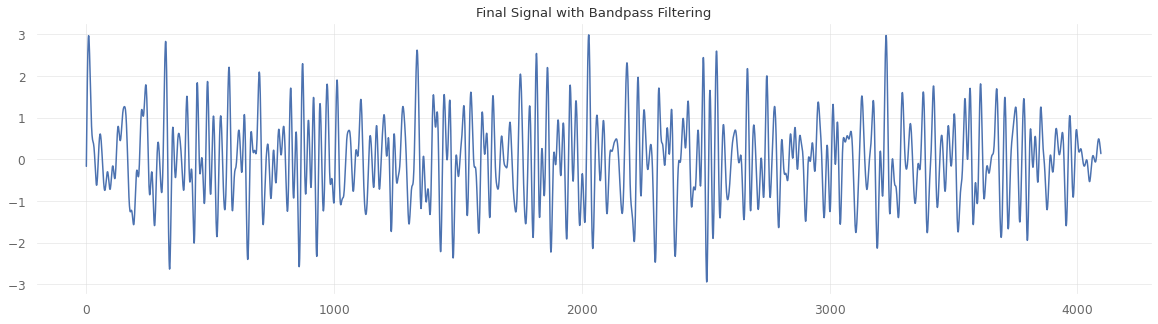

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(bandpassed_strain, '-')
plt.title('Final Signal with Bandpass Filtering')

https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer

In [ ]:
%%writefile tf_cwt.py
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License

import tensorflow as tf
from tensorflow import keras
import numpy as np
import math

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2, 'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
        self.n = n
    
    def call(self, inputs):
        x = tf.concat((tf.reverse(inputs[:,0:self.padvalue], axis=[1]), inputs, tf.reverse(inputs[:,-self.padvalue:], axis=[1])), axis=1)
        f = tf.signal.fft(tf.cast(x, tf.complex64))
        fr = tf.repeat(f, self.num_scales, axis=0)
        fr = tf.reshape(fr, (self.batch_size, self.num_scales, self.n))
        cwtcfs = tf.signal.ifft(fr * tf.cast(self.wft, tf.complex64))
        cfs = cwtcfs[:, :, self.padvalue:self.padvalue + inputs.shape[-1]]
        return tf.math.log(tf.math.abs(cfs))
    
# scale input to range 0.0 - upper
class Scaler(keras.layers.Layer):
    def __init__(self, upper=1.0):
        super(Scaler, self).__init__()
        self.upper = tf.cast(upper, dtype=tf.float32) # upper value (typically 1.0 or 255.0 for image CNNs)
    
    def call(self, inputs):
        min_val = tf.math.reduce_min(inputs)
        max_val = tf.math.reduce_max(tf.math.subtract(inputs, min_val))
        return tf.math.multiply(tf.math.subtract(inputs, min_val), self.upper/max_val)
    
# Stack three channels into RGB image
class RGBStack(keras.layers.Layer):
    def __init__(self):
        super(RGBStack, self).__init__()
        
    def call(self, inputs):
        return tf.stack(inputs, axis = 3)

Writing tf_cwt.py


In [ ]:
d_raw = wave[0].numpy()
d = d_raw/np.max(d_raw)

In [ ]:
from tf_cwt import Wavelet1D, Scaler, RGBStack

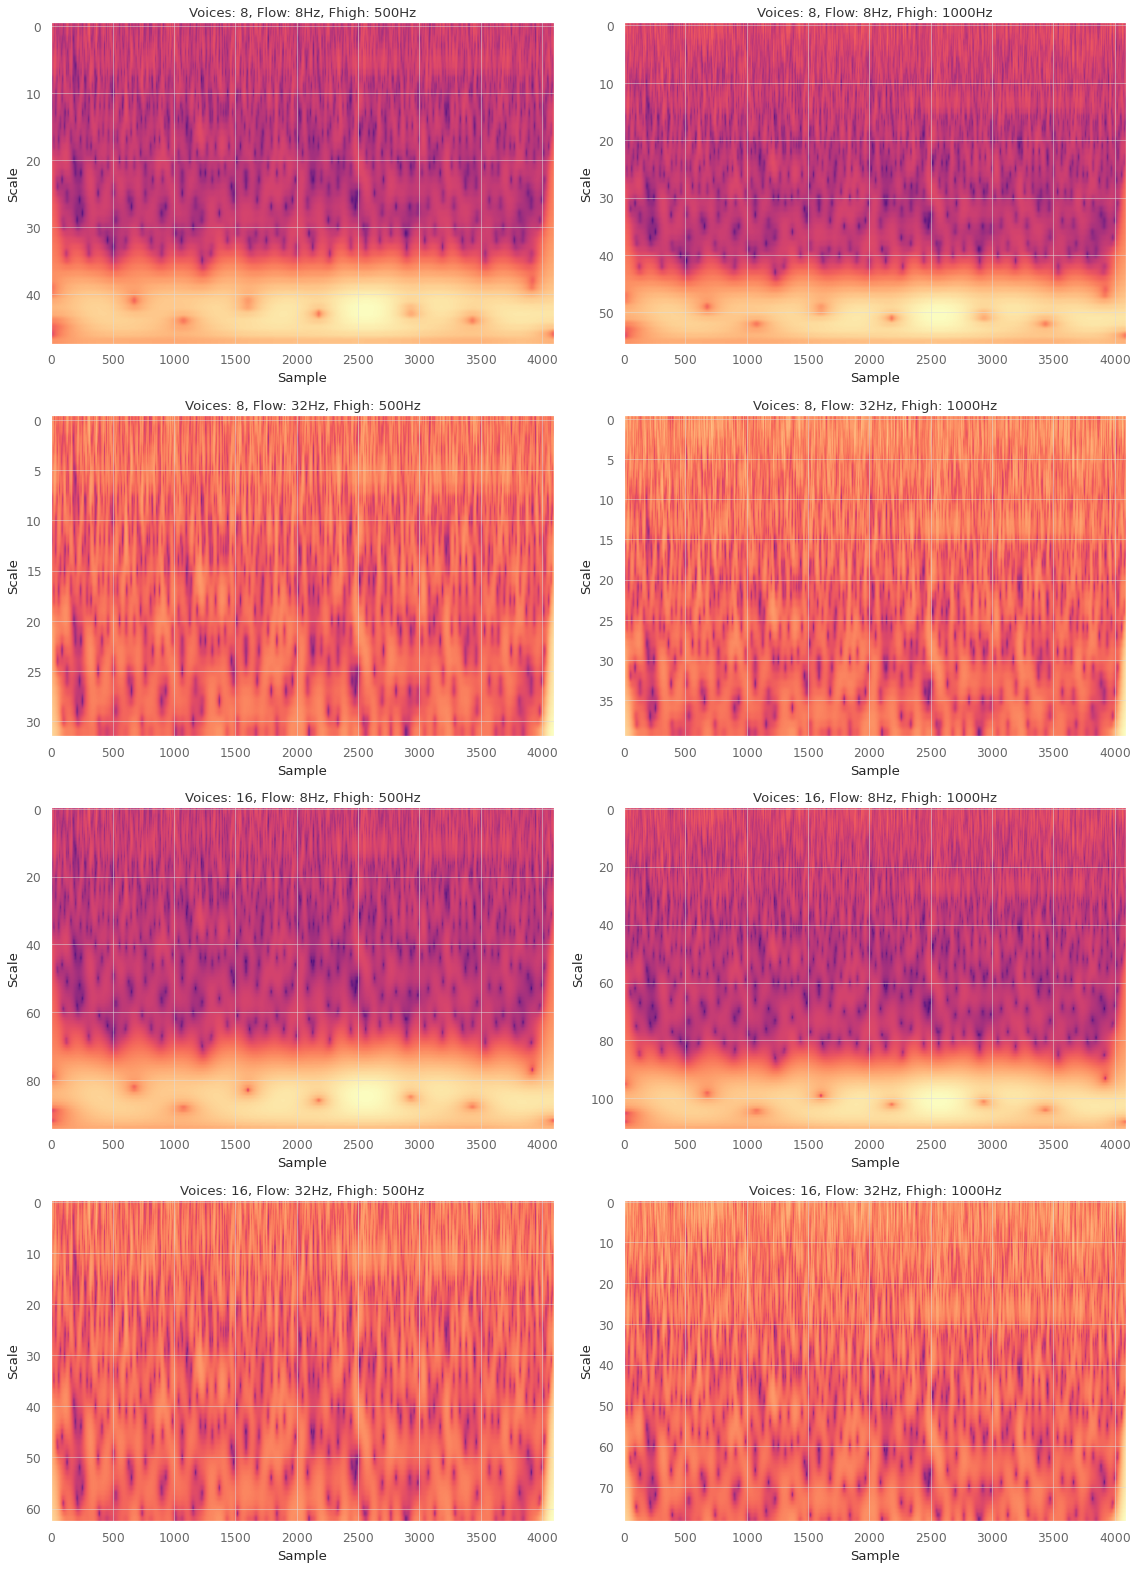

In [ ]:
fig = plt.figure(figsize=(16,22))
plt.tight_layout()
idx = 0
for nv in [8,16]:
    for flow in [8,32]:
        for fhigh in [500, 1000]:
            y = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=1)(tf.expand_dims(d, axis=0))
            y = Scaler(upper=1)(y)
            plt.tight_layout()
            ax = plt.subplot(4, 2, 1+idx)
            plt.xlabel('Sample')
            plt.ylabel('Scale')
            plt.title('Voices: {}, Flow: {}Hz, Fhigh: {}Hz'.format(nv, flow, fhigh))
            plt.imshow(np.squeeze(y.numpy()), cmap='magma', aspect='auto') 
            idx += 1

### Constant-Q Transform of the Time Series Data (using GWpy)

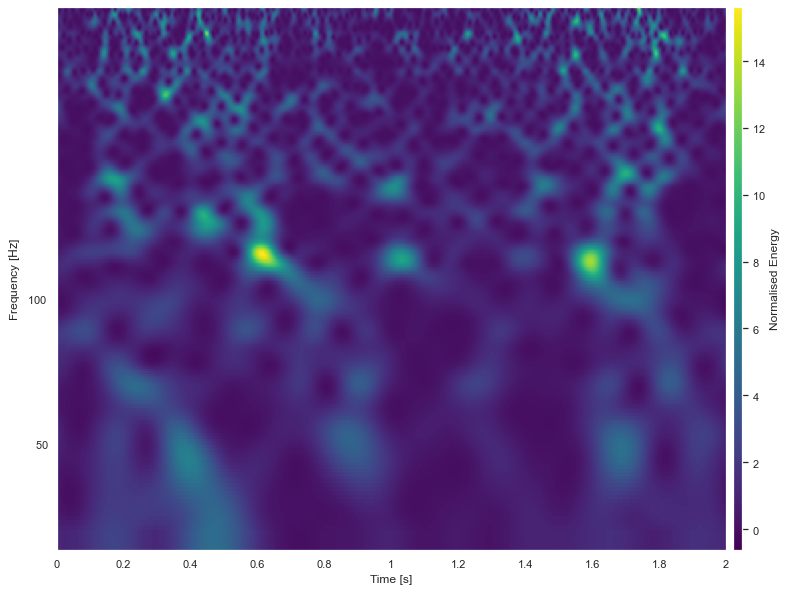

In [ ]:
p1, p2, p3 = preprocess(d1, d2, d3)
hq = p2.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
fig4 = hq.plot(figsize=[12, 10])
ax = fig4.gca()
fig4.colorbar(cmap='viridis', label="Normalised Energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Time [s]');

### Combining Signals with RGB 

In [ ]:
range_q = (16,32)
range_f = (30,400)

def combine_q_transforms(d1, d2, d3):
    p1, p2, p3 = preprocess(d1, d2, d3)
    # Q Transform each wave.
    _a = p1.q_transform(qrange=range_q, frange=range_f, logf=True, whiten=False)
    _b = p2.q_transform(qrange=range_q, frange=range_f, logf=True, whiten=False)
    _c = p3.q_transform(qrange=range_q, frange=range_f, logf=True, whiten=False)
    result = np.zeros([_a.shape[0], _a.shape[1], 3], dtype=np.uint8)
    scaler = MinMaxScaler()
    # Normalise for image
    result[:,:,0] = 255*scaler.fit_transform(_a)
    result[:,:,1] = 255*scaler.fit_transform(_b)
    result[:,:,2] = 255*scaler.fit_transform(_c)
    return Image.fromarray(result).rotate(90, expand=1).resize((256,256))

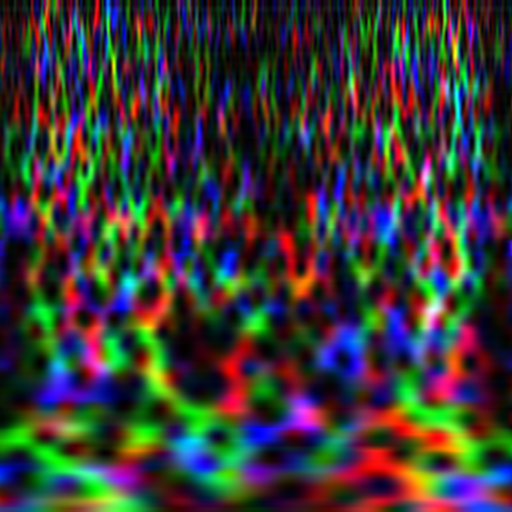

In [ ]:
combine_q_transforms(d1, d2, d3)

## Generating Spectrogram Images for Training and Testing

In [ ]:
# 446540 is missing/corrupt from data.

In [ ]:
IMG_SIZE = [512, 512]

In [ ]:
def save_image(file_path):
    file_name = file_path.split('/')[-1].split('.npy')[0]
    waves = np.load(file_path).astype(np.float32) # (3, 4096)
    melspecs = []
    for j in range(3):
        melspec = librosa.feature.melspectrogram(waves[j] / max(waves[j]), sr=4096, n_mels=128, fmin=20, fmax=2048)
        melspec = librosa.power_to_db(melspec)
        melspec = melspec.transpose((1, 0))
        melspecs.append(melspec)
    image = np.vstack(melspecs)
    image = resize(image, (54, 256))
    np.save(OUT_DIR + file_name, image)

In [ ]:
OUT_DIR = "test/images/"
os.mkdir(OUT_DIR)

In [ ]:
_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(save_image)(file_path) for file_path in tqdm(test['file_path'].values)
)

  0%|          | 0/226000 [00:00<?, ?it/s]

In [ ]:
OUT_DIR = "train/images/"
# os.mkdir(OUT_DIR)

In [ ]:
train.iloc[446540]

id        cc5e48ed32
target             0
Name: 446540, dtype: object

In [ ]:
train = train.drop(446540)

In [ ]:
_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(save_image)(file_path) for file_path in tqdm(train['file_path'].values)
)

  0%|          | 0/559999 [00:00<?, ?it/s]

In [ ]:
pre_testing_data = test

# Generating TFRecords

In [ ]:
def get_image_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "{}/{}/{}.npy".format(
        folder, 'images', image_id 
    )

In [ ]:
pre_training_data = train.drop(446540)

In [ ]:
training_data = []
for i in tqdm(range(len(pre_training_data))):
    training_path = get_image_path(pre_training_data['id'].iloc[i])
    training_image = np.load(training_path)
    training_data.append([training_image, pre_training_data['target'].iloc[i]])

NameError: ignored

## Sharding the Data

https://www.tensorflow.org/tutorials/load_data/tfrecord

### Utility Functions

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a floast_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

#### For Images

In [ ]:
def parse_single_image(image, label):
  
    #define the dictionary -- the structure -- of our single example
    data = {
        'height' : _int64_feature(image.shape[0]),
        'width' : _int64_feature(image.shape[1]),
#         'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image)),
        'label' : _int64_feature(label)
    }
    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))

    return out

In [ ]:
def get_images(image_ids, index_start, index_end):
    training_images = []
    training_image = np.empty
    ids = image_ids[index_start:index_end]
    
    for i in ids:
        training_path = get_image_path(i)
        training_image = np.load(training_path)
        training_images.append(training_image)
        
    return training_images

In [ ]:
# Create a dictionary with features that may be relevant.
def parse_image(image_string, label):
    image_shape = image_string.shape

    feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string.tobytes()),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
def write_images_to_tfr(image_labels, samples_per_shard = 56000, filename='g2-gravitational-waves', OUT_DIR='tfrecords/'):
    
    # Determine how many shards are needed for the given maximum number of samples in each shard.
    shards = (len(image_labels)//samples_per_shard) + 1 
    
    if len(image_labels)%samples_per_shard == 0:
        shards-=1
    print(f"Using {shards} shard(s) for {len(image_labels)} files, with up to {samples_per_shard} samples per shard.")
    
    # Loop through and write upto the maximum number of samples for each shard.
    index_start = 0
    index_end = samples_per_shard
    for i in tqdm(range(shards)):
        print(f'Loading shard {i+1} into memory...')
        images = get_images(image_labels['id'], index_start, index_end)
        images_target = image_labels['target'][index_start:index_end]
        shard_name = f"{OUT_DIR}{i+1}_{shards}-{filename}.tfrecords"
        print(f'Shard {i+1} loaded.')
        
        writer = tf.io.TFRecordWriter(shard_name)
        
        for idx, image in enumerate(images):
            out = parse_image(image_string=image,label=images_target.iloc[idx])
            writer.write(out.SerializeToString())
        
        writer.close()
        index_start = index_start + samples_per_shard
        index_end = index_end + samples_per_shard

In [ ]:
write_images_to_tfr(image_labels=pre_training_data)

#### For Raw Arrays

In [ ]:
# Create a dictionary with features that may be relevant.
def parse_array(array, label):
    # array_shape = array.shape

    feature = {
      'label': _int64_feature(label),
      'array_raw': _bytes_feature(array.tobytes()),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
def get_raw_arrays(dataframe, index_start, index_end):
    training_arrays = []
    id_paths = dataframe['file_path'].iloc[index_start:index_end].tolist()

    for id_path in id_paths:
        arr = np.load(id_path)
        training_arrays.append(arr)
    return np.array(training_arrays)

In [ ]:
write_arrays_to_tfr(array_labels=pre_testing_data)

In [ ]:
write_arrays_to_tfr(array_labels=pre_training_data)

## Verifying Integrity by Reading from a TensorFlow Dataset 

In [ ]:
RAW_TRAINING_FILENAMES[0]

'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/1_20-g2-gravitational-waves.tfrecords'

In [ ]:
raw_array_dataset = tf.data.TFRecordDataset(RAW_TRAINING_FILENAMES[10])

image_feature_description = {
    'array_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_array_dataset = raw_array_dataset.map(_parse_image_function)

for array_feature in parsed_array_dataset.take(1):
    array = tf.io.decode_raw(array_feature['array_raw'], tf.float64)
    array = tf.reshape(array, (3,4096))
    array_label = array_feature['label']

print(array)
print(array_label)

tf.Tensor(
[[-5.94830548e-21 -5.84995448e-21 -5.42415169e-21 ... -6.06698987e-21
  -5.96345722e-21 -5.75778438e-21]
 [ 9.75407048e-22  4.52586118e-22  4.58643893e-23 ... -1.09608208e-20
  -1.09766636e-20 -1.10858129e-20]
 [-1.74871983e-21 -1.18286791e-21 -1.93223777e-21 ...  1.46502268e-21
   2.18644864e-21  1.54085934e-21]], shape=(3, 4096), dtype=float64)
tf.Tensor(1, shape=(), dtype=int64)


# Image Segmentation

## Determining Threshold

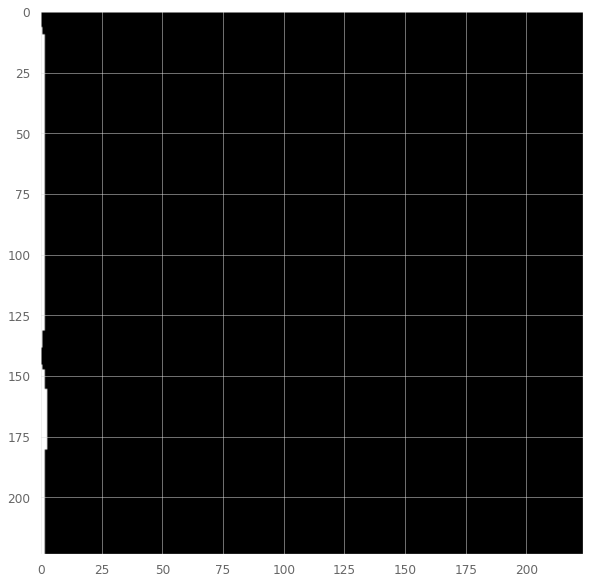

In [ ]:
raw_image_dataset = tf.data.TFRecordDataset(TRAINING_FILENAMES[0])

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
imgs = []
targets = []
for image_feature in parsed_image_dataset.take(2):
    height = image_feature['height']
    width = image_feature['width']
    image_raw = image_feature['image_raw']
    image = tf.io.decode_raw(image_feature['image_raw'],tf.float32)
    image = tf.reshape(image, (image_feature['height'], image_feature['width']))

    # Normalise image and apply color map. 
    image = colorize(image, cmap='viridis')
    image = tf.image.resize(image,(224,224))
    image *= 255
    image = tf.cast(image,tf.uint8)
    mask = image
    mask = mask[:, :, 0]
    logic1 = tf.math.logical_and(mask>=60, mask<=80)
    logic2 = tf.math.logical_and(mask>=130,mask<=150)
    mask = tf.where(mask>255//2,255,0)



    plt.imshow(mask,cmap='gray')
    imgs.append(image)
    targets.append(mask)
imgs = np.array(imgs)

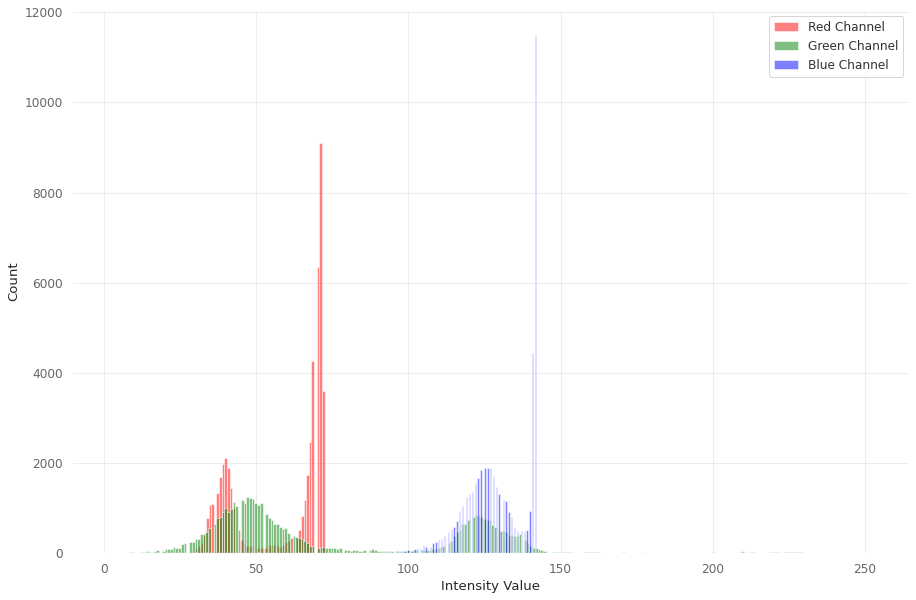

In [ ]:
_ = plt.hist(imgs[0][:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(imgs[0][:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(imgs[0][:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Frequency')
_ = plt.legend(['Red Channel', 'Green Channel', 'Blue Channel'])
plt.show()

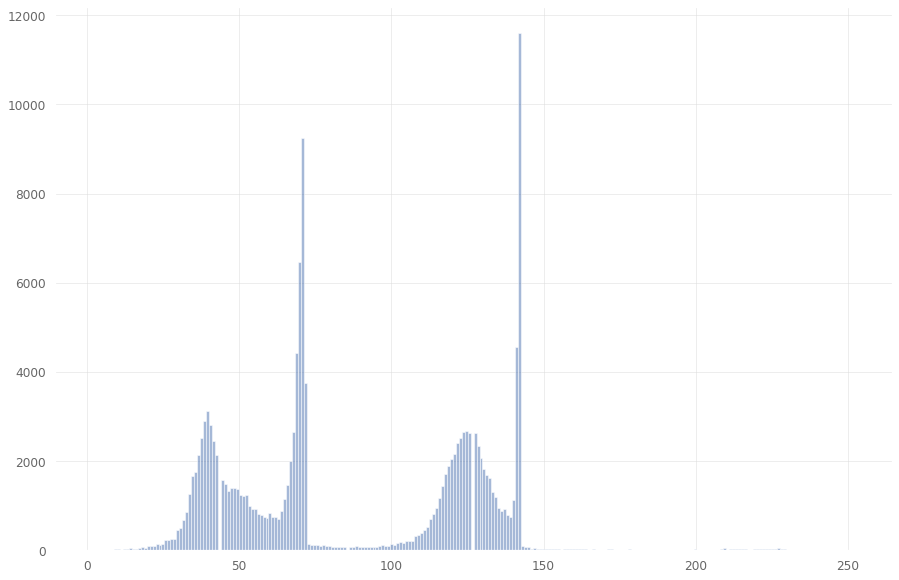

In [ ]:
_ = plt.hist(imgs[0][:, :].ravel(), bins = 256, alpha = 0.5)
plt.show()

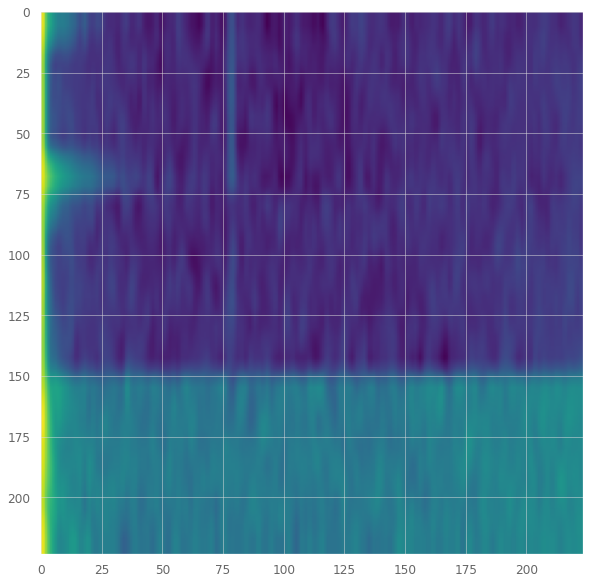

In [ ]:
plt.imshow(imgs[0])

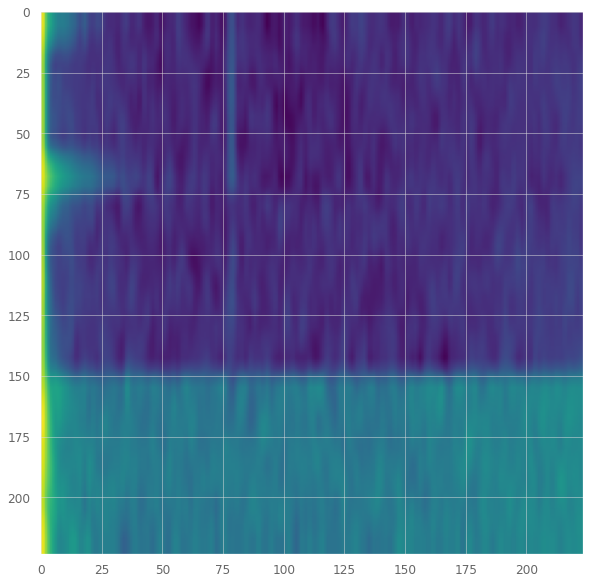

In [ ]:
plt.imshow(imgs[0])

In [ ]:
def load_dataset_segmentation(filenames, ordered = False, labeled = True):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)

    dataset = dataset.with_options(ignore_order)

    dataset = dataset.map(read_tfrecord_segmentation, num_parallel_calls = AUTO) 
    return dataset

In [ ]:
def get_training_dataset_segmentation(filenames):
    dataset = load_dataset_segmentation(filenames)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
train_dataset_segmentation = get_training_dataset_segmentation(TRAINING_FILENAMES)
train_dataset_segmentation = train_dataset_segmentation.map(lambda image, target: (image, target))

# Modelling

## Imports, Initial Parameters and Environment Setup

In [ ]:
from tensorflow.keras.applications import EfficientNetB6

In [13]:
# from tensorflow.keras.applications import EfficientNetB7
import efficientnet.tfkeras as efn

In [14]:
def hardware_strategy():
    print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Number of CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
    print('')
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU:', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
          tf.config.experimental_connect_to_cluster(tpu)
          tf.tpu.experimental.initialize_tpu_system(tpu)
          strategy = tf.distribute.TPUStrategy(tpu)
          policy = mixed_precision.Policy('mixed_bfloat16')
          mixed_precision.set_global_policy(policy)
          tf.config.optimizer.set_jit(True)
    else:
        strategy = tf.distribute.get_strategy()

    print("Number of Replicas in Sync: ", strategy.num_replicas_in_sync)
    return tpu, strategy
tpu, strategy = hardware_strategy()

Number of GPUs Available:  1
Number of CPUs Available:  1

Number of Replicas in Sync:  1


## For Librosa Images

In [ ]:
SEED = 42
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
VERBOSE = 1
NUM_TRAINING_IMAGES = 559999
EPOCHS = 18
LR = 0.0001
IMAGE_SIZE = [54,256]
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // (BATCH_SIZE * 4)
MODEL_DIR = '/content/drive/MyDrive/G2-Models'

In [ ]:
STEPS_PER_EPOCH

546

In [ ]:
IMG_TRAINING_FILENAMES

['gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/10_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/1_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/2_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/3_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/4_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/5_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/6_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/7_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/8_10-g2-gravitational-waves.tfrecords',
 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords/9_10-g2-gravitational-waves.tfrecords']

In [ ]:
def colorize(value, vmin=None, vmax=None, cmap=None):
    """
    A utility function for TensorFlow that maps a grayscale image to a matplotlib
    colormap for use with TensorBoard image summaries.
    By default it will normalize the input value to the range 0..1 before mapping
    to a grayscale colormap.
    Arguments:
      - value: 2D Tensor of shape [height, width] or 3D Tensor of shape
        [height, width, 1].
      - vmin: the minimum value of the range used for normalization.
        (Default: value minimum)
      - vmax: the maximum value of the range used for normalization.
        (Default: value maximum)
      - cmap: a valid cmap named for use with matplotlib's `get_cmap`.
        (Default: 'gray')
    Example usage:
    ```
    output = tf.random_uniform(shape=[256, 256, 1])
    output_color = colorize(output, vmin=0.0, vmax=1.0, cmap='viridis')
    tf.summary.image('output', output_color)
    ```
    
    Returns a 3D tensor of shape [height, width, 3].
    """

    # normalize
    vmin = tf.reduce_min(value) if vmin is None else vmin
    vmax = tf.reduce_max(value) if vmax is None else vmax
    value = (value - vmin) / (vmax - vmin) # vmin..vmax

    # squeeze last dim if it exists
    value = tf.squeeze(value)

    # quantize
    indices = tf.cast(tf.round(value * 255),tf.int32)

    # gather
    cm = plt.get_cmap(cmap if cmap is not None else 'gray')
    colors = cm(np.arange(256))[:, :3]
    colors = tf.constant(colors, dtype=tf.float32)
    value = tf.gather(colors, indices)

    return value

## (Slightly Altered) Colorisation - https://gist.github.com/jimfleming/c1adfdb0f526465c99409cc143dea97b#file-colorize-py

In [ ]:
def image_normalisation(tensor_arr):
    tensor = tf.truediv(
       tf.subtract(
          tensor_arr, 
          tf.reduce_min(tensor_arr)
       ), 
       tf.subtract(
          tf.reduce_max(tensor_arr), 
          tf.reduce_min(tensor_arr)
       )
    )
    return tensor
## Normalisation - https://stackoverflow.com/questions/38376478/changing-the-scale-of-a-tensor-in-tensorflow

In [ ]:
def read_tfrecord(example):
    TFREC_FORMAT = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    
    
    image = tf.io.decode_raw(example['image_raw'],tf.float32)
    image = tf.reshape(image, [54, 256])
    
    # Normalise image and apply color map. 
    image = colorize(image, cmap='viridis')
    
    target = tf.cast(example['label'], tf.float32)
    return image, target

In [ ]:
def load_dataset(filenames, ordered = False, labeled = True):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)

    dataset = dataset.with_options(ignore_order)

    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTO) 

    return dataset

In [ ]:
def get_training_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
train_dataset = get_training_dataset(TRAINING_FILENAMES)
train_dataset = train_dataset.map(lambda image, target: (image, target))

In [ ]:
def learning_rate_callback():
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LR, decay_steps=10000, decay_rate=0.7)
  lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = VERBOSE)
  return lr_callback

In [ ]:
from tensorflow_addons.optimizers import CyclicalLearningRate

In [ ]:
INIT_LR = LR
MAX_LR = 0.000015 * BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * STEPS_PER_EPOCH
)

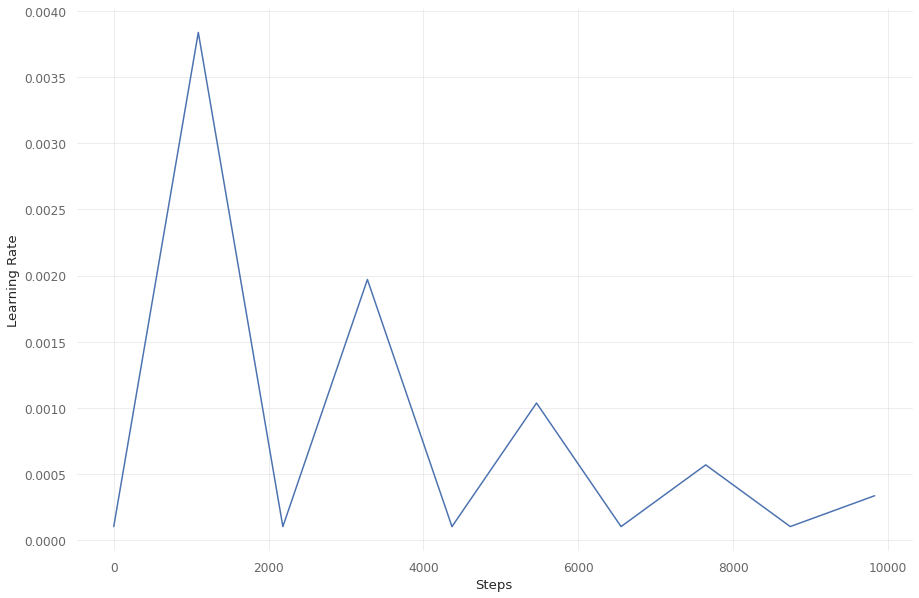

In [ ]:
step = np.arange(0, EPOCHS * STEPS_PER_EPOCH)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

Learning rate per epoch:


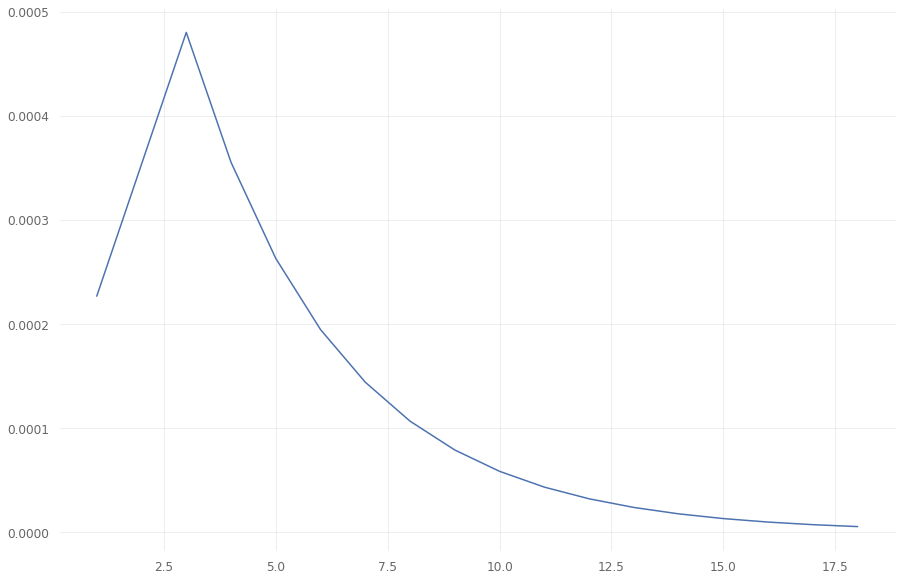

In [ ]:
start_lr = LR
min_lr = 0.0000001
max_lr = 0.000015 * BATCH_SIZE
rampup_epochs = 3
sustain_epochs = 0
exp_decay = .74

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(1,EPOCHS+1)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

## https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=iXJXG-Ufdbnu

In [ ]:
MODEL_NAME = 'G2-EfficientNetB7_model.h5'
checkpointer = tf.keras.callbacks.ModelCheckpoint(
        f'{MODEL_DIR}+{MODEL_NAME}',
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True)

In [ ]:
def get_model():
  inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3))
  x = EfficientNetB7(include_top = False, weights = 'imagenet')(inp)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
  model = tf.keras.models.Model(inputs = [inp], outputs = [output])
  opt = tf.keras.optimizers.AdamW(learning_rate = LR)
  opt = tfa.optimizers.SWA(opt)
  model.compile(
      optimizer = opt,
      loss = [tf.keras.losses.BinaryCrossentropy()],
      metrics = [tf.keras.metrics.AUC()] 
  )
  return model

In [ ]:
with strategy.scope():
  model = get_model()

258088960/258076736 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 54, 256, 3)]      0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,248
Trainable params: 63,789,521
Non-trainable params: 310,727
_________________________________________________________________


In [ ]:
hist = model.fit(train_dataset, steps_per_epoch = STEPS_PER_EPOCH, callbacks=[lr_callback], epochs = EPOCHS, verbose = VERBOSE)

In [ ]:
model.save_weights('./efn7_weights_7800.h5')

## Raw Signal Augmentations

### Setup

In [15]:
SEED = 42
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
VERBOSE = 1
NUM_TRAINING_ARRAYS = 559999
NUM_VALIDATION_ARRAYS = 226000
EPOCHS = 18
LR = 1e-4
IMAGE_SIZE = 256
STEPS_PER_EPOCH = NUM_TRAINING_ARRAYS // BATCH_SIZE // 4
MODEL_DIR = '/content/drive/MyDrive/G2-Models'

### Data Preprocessing

On the fly TPU CQT from: https://github.com/VincentWang25/G2Net_GoGoGo/blob/05b043a396184350af67897065749ea60513967b/isamu/notebooks/train_efficientnet-b7.ipynb

In [16]:
def create_cqt_kernels(
    q: float,
    fs: float,
    fmin: float,
    n_bins: int = 84,
    bins_per_octave: int = 12,
    norm: float = 1,
    window: str = "hann",
    fmax: Optional[float] = None,
    topbin_check: bool = True
) -> Tuple[np.ndarray, int, np.ndarray, float]:
    fft_len = 2 ** _nextpow2(np.ceil(q * fs / fmin))
    
    if (fmax is not None) and (n_bins is None):
        n_bins = np.ceil(bins_per_octave * np.log2(fmax / fmin))
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))
    elif (fmax is None) and (n_bins is not None):
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))
    else:
        warnings.warn("If nmax is given, n_bins will be ignored", SyntaxWarning)
        n_bins = np.ceil(bins_per_octave * np.log2(fmax / fmin))
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))
        
    if np.max(freqs) > fs / 2 and topbin_check:
        raise ValueError(f"The top bin {np.max(freqs)} Hz has exceeded the Nyquist frequency, \
                           please reduce the `n_bins`")
    
    kernel = np.zeros((int(n_bins), int(fft_len)), dtype=np.complex64)
    
    length = np.ceil(q * fs / freqs)
    for k in range(0, int(n_bins)):
        freq = freqs[k]
        l = np.ceil(q * fs / freq)
        
        if l % 2 == 1:
            start = int(np.ceil(fft_len / 2.0 - l / 2.0)) - 1
        else:
            start = int(np.ceil(fft_len / 2.0 - l / 2.0))

        sig = get_window(window, int(l), fftbins=True) * np.exp(
            np.r_[-l // 2:l // 2] * 1j * 2 * np.pi * freq / fs) / l
        
        if norm:
            kernel[k, start:start + int(l)] = sig / np.linalg.norm(sig, norm)
        else:
            kernel[k, start:start + int(l)] = sig
    return kernel, fft_len, length, freqs


def _nextpow2(a: float) -> int:
    return int(np.ceil(np.log2(a)))


def prepare_cqt_kernel(
    sr=22050,
    hop_length=512,
    fmin=32.70,
    fmax=None,
    n_bins=84,
    bins_per_octave=12,
    norm=1,
    filter_scale=1,
    window="hann"
):
    q = float(filter_scale) / (2 ** (1 / bins_per_octave) - 1)
    print(q)
    return create_cqt_kernels(q, sr, fmin, n_bins, bins_per_octave, norm, window, fmax)

In [17]:
HOP_LENGTH = 16
cqt_kernels, KERNEL_WIDTH, lengths, _ = prepare_cqt_kernel(
    sr=2048,
    hop_length=HOP_LENGTH,
    fmin=20,
    fmax=1024,
    bins_per_octave=24)
LENGTHS = tf.constant(lengths, dtype=tf.float32)
CQT_KERNELS_REAL = tf.constant(np.swapaxes(cqt_kernels.real[:, np.newaxis, :], 0, 2))
CQT_KERNELS_IMAG = tf.constant(np.swapaxes(cqt_kernels.imag[:, np.newaxis, :], 0, 2))
PADDING = tf.constant([[0, 0],
                        [KERNEL_WIDTH // 2, KERNEL_WIDTH // 2],
                        [0, 0]])

34.12708770892056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SyntaxWarning:

If nmax is given, n_bins will be ignored



In [18]:
def create_cqt_image(wave, hop_length=16):
    CQTs = []
    for i in range(3):
        x = wave[i]
        x = tf.expand_dims(tf.expand_dims(x, 0), 2)
        x = tf.pad(x, PADDING, "REFLECT")

        CQT_real = tf.nn.conv1d(x, CQT_KERNELS_REAL, stride=hop_length, padding="VALID")
        CQT_imag = -tf.nn.conv1d(x, CQT_KERNELS_IMAG, stride=hop_length, padding="VALID")
        CQT_real *= tf.math.sqrt(LENGTHS)
        CQT_imag *= tf.math.sqrt(LENGTHS)

        CQT = tf.math.sqrt(tf.pow(CQT_real, 2) + tf.pow(CQT_imag, 2))
        CQTs.append(CQT[0])
    return tf.stack(CQTs, axis=2)

In [19]:
def prepare_image(wave, dim=256):
    wave = tf.reshape(tf.io.decode_raw(wave, tf.float64), (3, 4096))
    normalized_waves = []
    for i in range(3):
        normalized_wave = wave[i] / tf.math.reduce_max(wave[i])
        normalized_waves.append(normalized_wave)
    wave = tf.stack(normalized_waves)
    wave = tf.cast(wave, tf.float32)
    image = create_cqt_image(wave, HOP_LENGTH)
    image = tf.image.resize(image, size=(dim, dim))
    return tf.reshape(image, (dim, dim, 3))

### Testing TFRecords and Printing Dataset Sample

In [131]:
raw_array_dataset =tf.data.TFRecordDataset(RAW_TRAINING_FILENAMES[0])

image_feature_description = {
    'array_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_array_dataset = raw_array_dataset.map(_parse_image_function)

for array_feature in parsed_array_dataset.take(1):
    wave = tf.reshape(tf.io.decode_raw(array_feature['array_raw'], tf.float64), (3, 4096))
    wave_image = prepare_image(array_feature['array_raw'], IMAGE_SIZE)
    array_label = array_feature['label']

print(wave)
print(array_label)

tf.Tensor(
[[-2.26507773e-20 -2.26824133e-20 -2.25903500e-20 ...
  -5.67574839e-21 -5.50066522e-21 -5.24939453e-21]
 [-2.15955645e-21 -1.40929943e-21 -1.12841005e-21 ...
  -2.59002878e-21 -2.41799662e-21 -2.47120394e-21]
 [-1.08335506e-21 -4.39757865e-22 -8.44554026e-22 ...
   1.14054592e-21  9.07295975e-22  1.16912789e-21]], shape=(3, 4096), dtype=float64)
tf.Tensor(1, shape=(), dtype=int64)


### Reading TFRecords

In [ ]:
def wave_read_tfrecord(example):
    TFREC_FORMAT = {
    'array_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    

    # Waves to CQT Image
    wave = prepare_image(example['array_raw'], IMAGE_SIZE)
   
    target = tf.reshape(tf.cast(example["label"], tf.float32), [1])

    # target = tf.cast(example["label"], tf.float32)
    return wave, target

In [ ]:
def wave_unlabeled_read_tfrecord(example):
    TFREC_FORMAT = {
    'array_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    

    # Waves to CQT Image
    wave = prepare_image(example['array_raw'], IMAGE_SIZE)
   

    # target = tf.cast(example["label"], tf.float32)
    return wave

In [ ]:
def wave_get_dataset(filenames, shuffle=True, repeat=True, labeled=True, aug=False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.cache()

    if repeat:
        dataset = dataset.repeat()

    if shuffle:
        dataset = dataset.shuffle(2048)
        options = tf.data.Options()
        options.experimental_deterministic = False
        dataset = dataset.with_options(options)

    if labeled:
        dataset = dataset.map(wave_read_tfrecord, num_parallel_calls=AUTO)
    else:
        dataset = dataset.map(lambda example: wave_unlabeled_read_tfrecord(example), num_parallel_calls=AUTO)

    dataset = dataset.batch(BATCH_SIZE)

    if aug:
        dataset = dataset.map(lambda x, y: aug_f(x, y, BATCH_SIZE), num_parallel_calls=AUTO)

    dataset = dataset.prefetch(AUTO)
    return dataset

### Learning Rates

In [ ]:
def learning_rate_callback():
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LR, decay_steps=10000, decay_rate=0.7)
  lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = VERBOSE)
  return lr_callback

In [ ]:
from tensorflow_addons.optimizers import CyclicalLearningRate

In [ ]:
INIT_LR = LR
MAX_LR = 0.000015 * BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * STEPS_PER_EPOCH
)

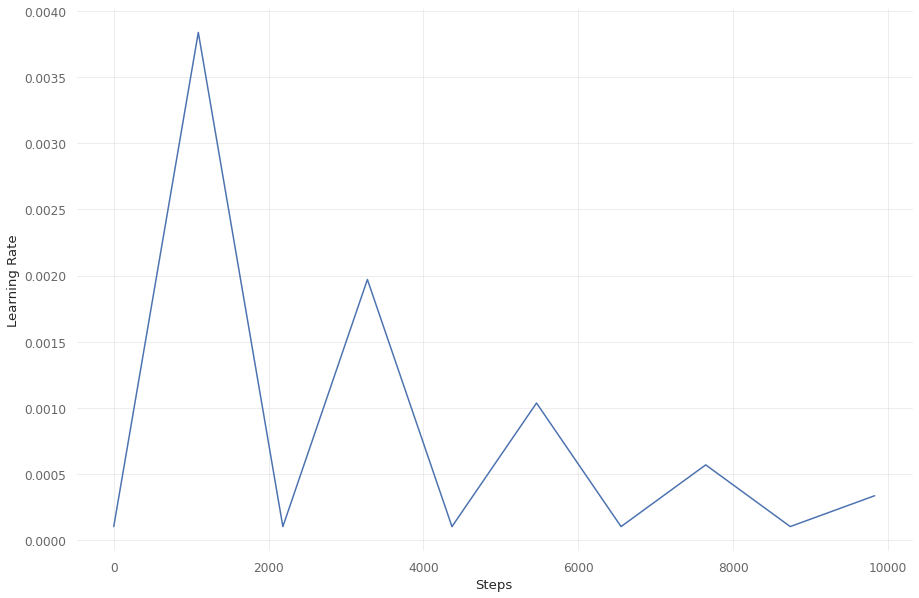

In [ ]:
step = np.arange(0, EPOCHS * STEPS_PER_EPOCH)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
start_lr = LR
min_lr = 1e-7
max_lr = 0.000015 * BATCH_SIZE
rampup_epochs = 3
sustain_epochs = 0
exp_decay = .74

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

Learning rate per epoch:


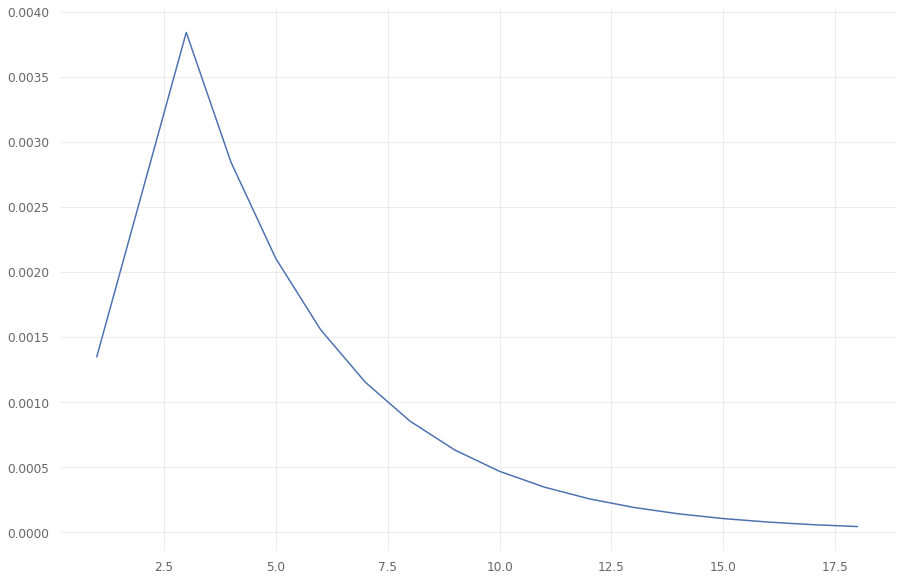

In [ ]:
rang = np.arange(1,EPOCHS+1)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [ ]:
def get_lr_callback():
  start_lr = LR
  min_lr = 1e-7
  max_lr = 0.000015 * BATCH_SIZE
  rampup_epochs = 3
  sustain_epochs = 0
  exp_decay = .74

  def lrfn(epoch):
    if epoch < rampup_epochs:
      return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
      return max_lr
    else:
      return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
      
  lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

  return lr_callback
## https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=iXJXG-Ufdbnu

## Non-Pretrained 2D CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

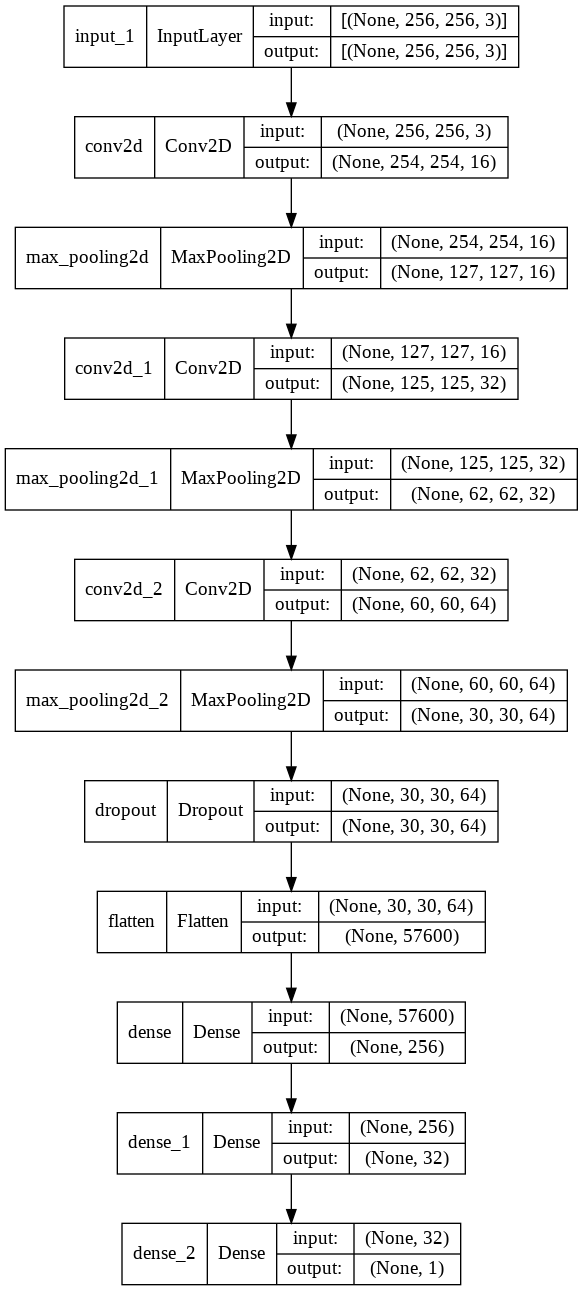

In [18]:
# with strategy.scope():
tf.keras.backend.clear_session()
cnn_model = Sequential()
cnn_model.add(Input(shape=(256,256,3)))
for i in [16,32,64]:
  cnn_model.add(Conv2D(filters=i, kernel_size=3, activation='relu'))
  cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(256,'relu'))
cnn_model.add(Dense(32, 'relu'))
cnn_model.add(Dense(1, 'sigmoid'))
cnn_model.summary()
keras.utils.plot_model(cnn_model, show_shapes=True)

## EfficientNetB7

### Building Model

In [ ]:
MODEL_NAME = 'wave_G2-EfficientNetB7_model.h5'
checkpointer = tf.keras.callbacks.ModelCheckpoint(
        f'{MODEL_DIR}+{MODEL_NAME}',
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True)

In [33]:
def build_cnn_efn_model():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    efficientnet_layer = getattr(efn, "EfficientNetB7")(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

    x = efficientnet_layer(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)

    lr_decayed_fn = tf.keras.experimental.CosineDecay(1e-3, NUM_TRAINING_ARRAYS // BATCH_SIZE // 4)
    opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate=LR)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=opt, loss=loss, metrics=["AUC"])
    return model

In [34]:
with strategy.scope():
  cnn_efn_model = build_cnn_efn_model()

258449408/258434480 [==============================] - 7s 0us/step


In [35]:
cnn_efn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnet-b7 (Functional  (None, 8, 8, 2560)       64097680  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 1)                 2561      
                                                                 
Total params: 64,100,241
Trainable params: 63,789,521
Non-tra

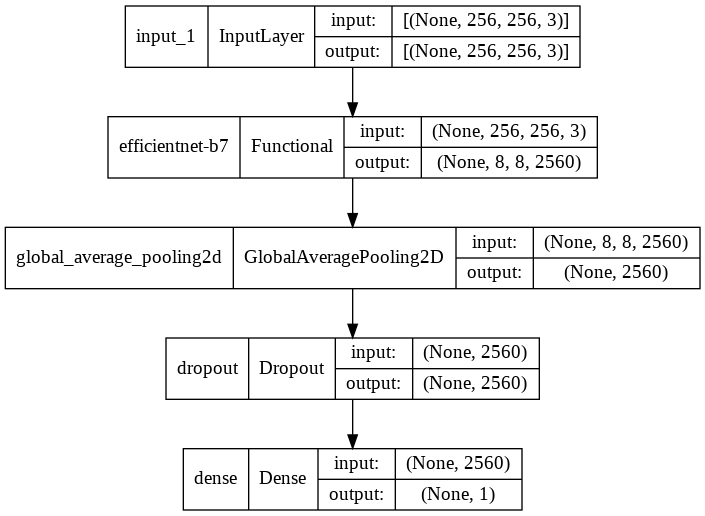

In [36]:
keras.utils.plot_model(cnn_efn_model, show_shapes=True)

## Training with KFolds

In [ ]:
from sklearn.model_selection import KFold
from pathlib import Path

In [ ]:
NUM_OF_FOLDS = 4
kf = KFold(n_splits=NUM_OF_FOLDS, shuffle=True, random_state=42)
oof_pred = []
oof_target = []

In [ ]:
model_name = 'cnn_efnb7' # Change model name to the current model we're training
MODELS_DIR = Path(f"drive/MyDrive/G2/Models/{model_name}/")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

OOF_DIR = Path(f"drive/MyDrive/G2/Models/{model_name}/OOF/")
OOF_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
def shard_sample_count(shard):
  if str(shard) == 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_train_raw/20_20-g2-gravitational-waves.tfrecords':
    return 27999
  if str(shard) == 'gs://g2-gravitational-waves-tfrecords_bucket/tfrecords_test_raw/9_9-g2-gravitational-waves.tfrecords':
    return 2000
  else:
    return 28000

In [ ]:
def shards_sample_count(shards):
  total_count = 0
  for shard in shards:
    total_count += shard_sample_count(shard)
  return total_count

In [ ]:
for fold, (train_idx, validation_idx) in enumerate(kf.split(RAW_TRAINING_FILENAMES)):

  TRAINING_FILENAMES = np.array(RAW_TRAINING_FILENAMES)[train_idx]
  VALIDATION_FILENAMES = np.array(RAW_TRAINING_FILENAMES)[validation_idx]

  TRAINING_SAMPLE_COUNT = shards_sample_count(TRAINING_FILENAMES)
  VALIDATION_SAMPLE_COUNT = shards_sample_count(VALIDATION_FILENAMES)


  tf.keras.backend.clear_session()
  tpu, strategy = get_hardware_strategy()
  with strategy.scope():
    model = build_cnn_efn_model()

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    str(MODELS_DIR / f"Fold_{fold}.h5"), monitor="val_auc", verbose=1, save_best_only=True,
    save_weights_only=True, mode="max", save_freq="epoch"
  )
  
  print('-' * 100)
  print(f'Fold Number: {fold+1}')
  print('-' * 100)

  history = model.fit(wave_get_dataset(TRAINING_FILENAMES), validation_data=wave_get_dataset(VALIDATION_FILENAMES, repeat=False, shuffle=False), 
                   steps_per_epoch = STEPS_PER_EPOCH, callbacks=[get_lr_callback(), ckpt_callback], epochs = EPOCHS, verbose = VERBOSE)
  
  model.load_weights(str(MODELS_DIR / f"Fold_{fold}.h5"))

  VALIDATION_DATASET = wave_get_dataset(VALIDATION_FILENAMES, labeled=False, repeat=True, shuffle=False, aug=False)
  STEPS = VALIDATION_SAMPLE_COUNT / (BATCH_SIZE / strategy.num_replicas_in_sync) / strategy.num_replicas_in_sync
  pred = model.predict(VALIDATION_DATASET, steps=STEPS, verbose=0)[:VALIDATION_SAMPLE_COUNT]
  oof_pred.append(np.mean(pred.reshape((VALIDATION_SAMPLE_COUNT, 1), order="F"), axis=1))

  VALIDATION_DATASET = wave_get_dataset(VALIDATION_FILENAMES, repeat=False, labeled=True, aug=False)
  oof_target.append(np.array([target.numpy() for img, target in iter(VALIDATION_DATASET.unbatch())]))

Number of GPUs Available:  0
Number of CPUs Available:  1

Running on TPU: grpc://10.117.104.26:8470


Number of Replicas in Sync:  8
258449408/258434480 [==============================] - 6s 0us/step
----------------------------------------------------------------------------------------------------
Fold Number: 1
----------------------------------------------------------------------------------------------------

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/18
546/546 [==============================] - ETA: 0s - loss: 0.5225 - auc: 0.7943
Epoch 00001: val_auc improved from -inf to 0.81333, saving model to drive/MyDrive/G2/Models/cnn_efnb7/Fold_0.h5
546/546 [==============================] - 764s 780ms/step - loss: 0.5225 - auc: 0.7943 - val_loss: 0.5609 - val_auc: 0.8133 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0013466666666666668.
Epoch 2/18
546/546 [==============================] - ETA: 0s - loss: 0.4794 - auc: 0.8260
Epoch 00002: val_auc improved from 0.81333 to 0.84895, saving model to drive/MyDrive/G2/Models/c

# Model Interpretability

In [ ]:
!pip install librosa

In [ ]:
import librosa
from skimage.transform import resize

In [ ]:
def save_image_new(file_path):
    file_name = file_path.split('/')[-1].split('.npy')[0]
    waves = np.load(file_path).astype(np.float32) # (3, 4096)
    melspecs = []
    for j in range(3):
        melspec = librosa.feature.melspectrogram(waves[j] / max(waves[j]), sr=4096, n_mels=128, fmin=20, fmax=2048)
        melspec = librosa.power_to_db(melspec)
        melspec = melspec.transpose((1, 0))
        melspecs.append(melspec)
    image = np.vstack(melspecs)
    image = resize(image, (54, 256))
    np.save('/content/drive/MyDrive/images/'+ file_name, image)

In [ ]:
save_image_new('/content/drive/MyDrive/00000e74ad.npy')

In [ ]:
image = np.load('/content/drive/MyDrive/images/00000e74ad.npy')

In [ ]:
image =colorize(image, cmap='viridis')

In [ ]:
test_dataset = test_dataset.map(lambda image, target: image)

In [ ]:
q = model.predict(np.array([image,]))

In [ ]:
img = tf.keras.preprocessing.image.img_to_array(image)

In [ ]:
!pip install tf-explain

In [ ]:
vit_model = tf.keras.models.load_model('/content/drive/MyDrive/G2/Models/vit_b16/Fold_0.h5')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
image = image.numpy()
image = np.array(Image.fromarray((image * 255).astype(np.uint8)))
image = Image.fromarray(image)
image.save("image1.jpeg")

In [ ]:
import tensorflow as tf

from tf_explain.core.smoothgrad import SmoothGrad

IMAGE_PATH = '/content/image1.jpeg'

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(54, 256))
img = tf.keras.preprocessing.image.img_to_array(img)

model.summary()
data = ([img], None)

tabby_cat_class_index = 1001
explainer = SmoothGrad()

grid = explainer.explain(data, model, tabby_cat_class_index, 40, 1.)
explainer.save(grid, '.', 'smoothgrad'+str(tabby_cat_class_index)+'.png')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 54, 256, 3)]      0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2561      
Total params: 64,100,248
Trainable params: 63,789,521
Non-trainable params: 310,727
_________________________________________________________________


# Visualising the Visual Transformer (for the Librosa Images)

In [ ]:
import sys
sys.path.insert(1, './content/utils')

In [ ]:
from utils.transformer import TransformerEncoder, PatchClassEmbedding, Patches
from utils.visualize import plotPatches, plotHistory
from utils.tools import CustomSchedule
from pathlib import Path
import cv2

In [ ]:
input_shape = (224,224,3)
TEST_SIZE = 0.2
PATCH_SIZE = 16
NUM_PATCHES = (input_shape[0]//PATCH_SIZE)**2

In [ ]:
def read_tfrecord_transformer(example):
    TFREC_FORMAT = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    
    
    image = tf.io.decode_raw(example['image_raw'],tf.float32)
    image = tf.reshape(image, (example['height'], example['width']))
    # Normalise image and apply color map. 
    image = colorize(image, cmap='viridis')
    image.set_shape([54,256,3])
    image = tf.image.resize(image,(224,224))
    image *= 255
    image = tf.cast(image,tf.uint8)
 
    target = tf.cast(example['label'], tf.float32)
    return image, target

In [ ]:
def load_dataset_transformer(filenames, ordered = False, labeled = True):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord_transformer, num_parallel_calls = AUTO) 
    return dataset

In [ ]:
def get_training_dataset_transformer(filenames):
    dataset = load_dataset_transformer(filenames)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
train_dataset_transformer = get_training_dataset_transformer(IMG_TRAINING_FILENAMES)
train_dataset_transformer = train_dataset_transformer.map(lambda image, target: (image, target))

In [ ]:
raw_image_dataset = tf.data.TFRecordDataset(IMG_TRAINING_FILENAMES[0])

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
imgs = []
targets = []
for image_feature in parsed_image_dataset.take(2):
    height = image_feature['height']
    width = image_feature['width']
    image_raw = image_feature['image_raw']
    image = tf.io.decode_raw(image_feature['image_raw'],tf.float32)
    image = tf.reshape(image, (image_feature['height'], image_feature['width']))

    # Normalise image and apply color map. 
    image = colorize(image, cmap='viridis')
    # image = cv2.resize(image.numpy(),(224,224))
    image = tf.image.resize(image,(224,224))
    # image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image *= 255
    image = tf.cast(image,tf.uint8)
    target = tf.cast(image_feature['label'], tf.float32)
    imgs.append(image)
    targets.append(target)
imgs = np.array(imgs)

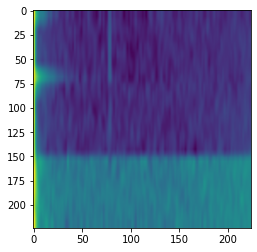

In [ ]:
plt.imshow(imgs[0])

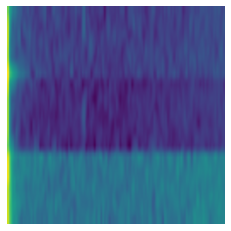

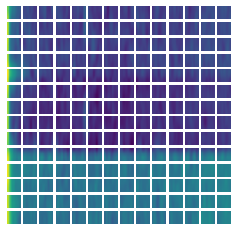

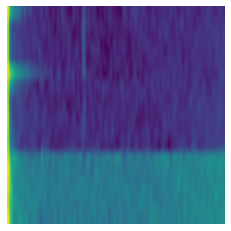

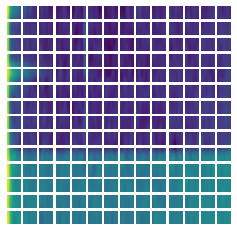

In [ ]:
plotPatches(imgs,n_images=2, patch_size=PATCH_SIZE)

# Keras Vision Transformer

In [ ]:
def build_vit_model():
  vit_model = vit.vit_b16(
      image_size = (256 , 256),
      activation = 'softmax',
      pretrained = True,
      include_top = False,
      pretrained_top = False,
      classes = 2)

  inputs = tf.keras.layers.Input(shape=(256, 256, 3))
  x = vit_model(inputs)
  # x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  # x = tf.keras.layers.Dense(128, activation = tfa.activations.gelu)(x)
  x = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)

  lr_decayed_fn = tf.keras.experimental.CosineDecay(1e-3, NUM_TRAINING_ARRAYS // BATCH_SIZE // 4)
  opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate = LR)
  # opt = tfa.optimizers.SWA(opt)

  model.compile(
    optimizer = opt,
    loss = [tf.keras.losses.BinaryCrossentropy()],
    metrics = [tf.keras.metrics.AUC()] 
  )
  return model

In [ ]:
with strategy.scope():
  vit_model = build_vit_model()

347512832/347502902 [==============================] - 9s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning:

Resizing position embeddings from 24, 24 to 16, 16



In [ ]:
vit_model.load_weights('/content/drive/MyDrive/G2/Models/vit_b16/Fold_0.h5')

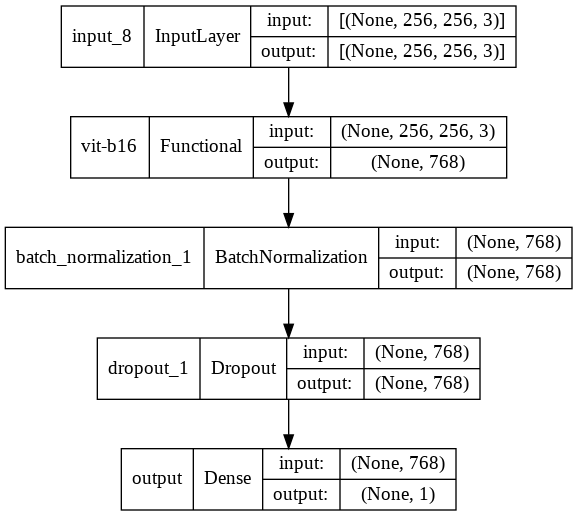

In [ ]:
keras.utils.plot_model(vit_model, show_shapes=True)

In [ ]:
train_history = vit_model.fit(
    wave_train_dataset, 
    epochs=18,
    callbacks=[get_lr_callback()],
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=1
)

In [ ]:
vit_model.save_weights('./vit_CQT_Transform.h5'))

## Visualing Attention Maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


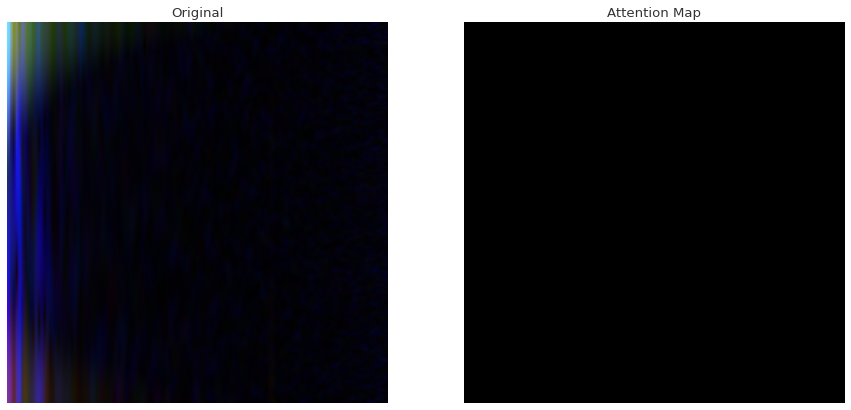

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg'
image = utils.read(url, image_size)

for image in wave_images:

  attention_map = visualize.attention_map(model=vit_model.layers[1], image=image)
  # print('Prediction:', classes[
  #     model.predict(vit.preprocess_inputs(image.numpy())[np.newaxis])[0].argmax()]
  # )

  # Plot results
  fig, (ax1, ax2) = plt.subplots(ncols=2)
  ax1.axis('off')
  ax2.axis('off')
  ax1.set_title('Original')
  ax2.set_title('Attention Map')
  _ = ax1.imshow(image.numpy())
  _ = ax2.imshow(attention_map)

## https://github.com/faustomorales/vit-keras#readme 

# 1-Dimensional Convolutional Neural Network for Time Series Classification

## Data Preprocessing

In [ ]:
def raw_wave_read_tfrecord(example):
    TFREC_FORMAT = {
    'array_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    # wave = tf.reshape(tf.io.decode_raw(example['array_raw'], tf.float64), (4096, 3))

    wave = tf.reshape(tf.io.decode_raw(example['array_raw'], tf.float64), (3, 4096))
    # wave = tf.reshape(wave, (1, 3, 4096))

    target = tf.cast(example['label'], tf.float32)
    return wave, target

In [ ]:
def raw_wave_load_dataset(filenames, ordered = False, labeled = True):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)

    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(raw_wave_read_tfrecord, num_parallel_calls = AUTO) 
    return dataset

In [ ]:
def raw_wave_get_training_dataset(filenames):
    dataset = raw_wave_load_dataset(filenames)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
raw_wave_train_dataset = raw_wave_get_training_dataset(RAW_TRAINING_FILENAMES)
raw_wave_train_dataset = raw_wave_train_dataset.map(lambda wave, target: (wave, target))

In [ ]:
raw_wave_train_dataset

<MapDataset shapes: ((None, 4096, 3), (None, 1)), types: (tf.float64, tf.float32)>

In [ ]:
raw_wave_testing_dataset = raw_wave_get_training_dataset(RAW_TESTING_FILENAMES)
raw_wave_testing_dataset = raw_wave_testing_dataset.map(lambda wave, target: (wave, target))

## Building Model and Training

In [ ]:
SEED = 42
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1000 * strategy.num_replicas_in_sync
VERBOSE = 1
NUM_TRAINING_ARRAYS = 559999
NUM_VALIDATION_ARRAYS = 226000
EPOCHS = 50
LR = 1e-4
IMAGE_SIZE = 256
STEPS_PER_EPOCH = NUM_TRAINING_ARRAYS // BATCH_SIZE // 4
MODEL_DIR = '/content/drive/MyDrive/G2-Models'

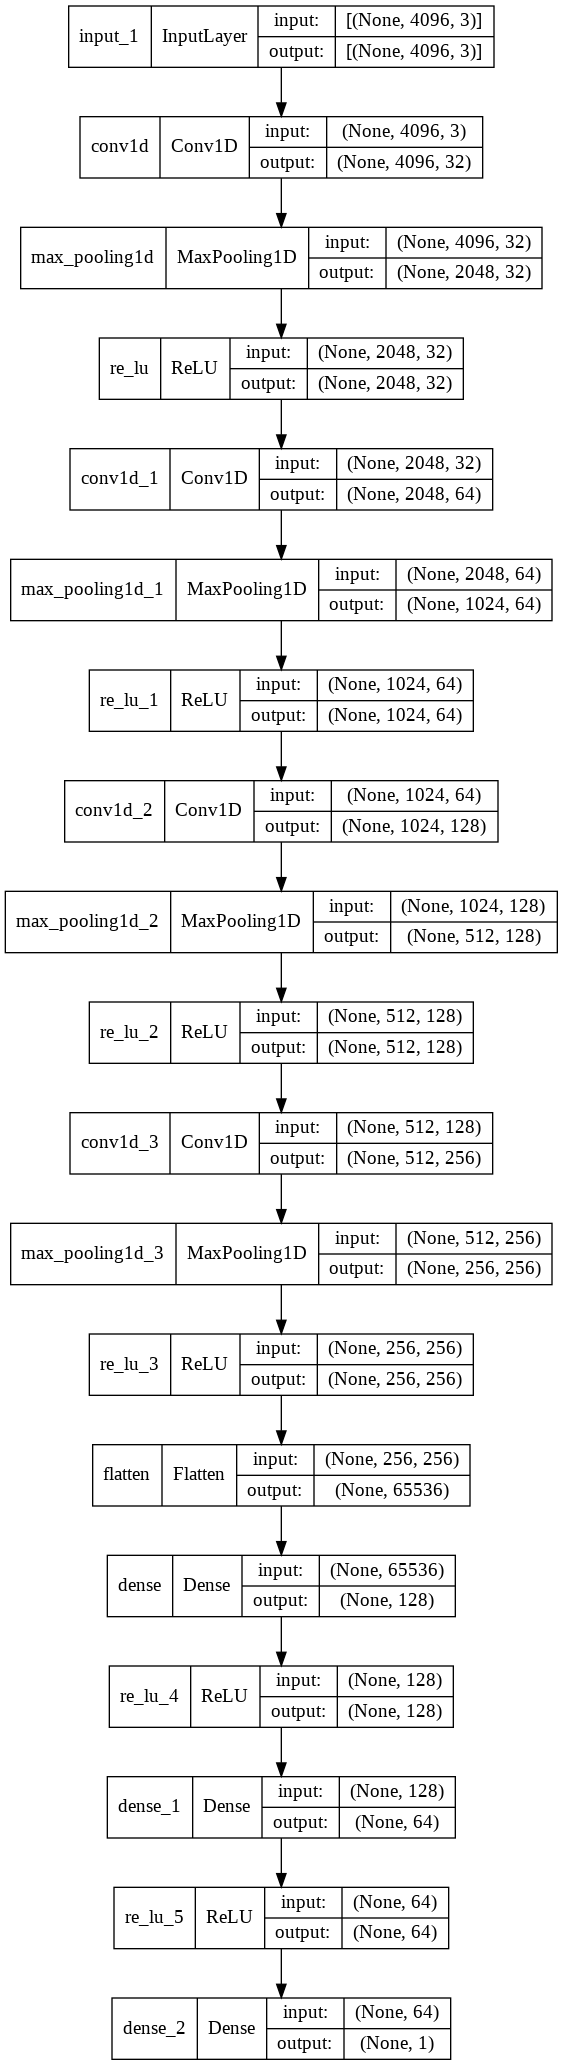

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)


    # x = keras.layers.BatchNormalization()(input_layer)
    conv1 = keras.layers.Conv1D(filters=32, kernel_size=16, padding="same")(input_layer)
    conv1 = tf.keras.layers.MaxPooling1D(pool_size=4, strides=2, padding='same')(conv1)
    # conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=8, padding="same")(conv1)
    conv2 = tf.keras.layers.MaxPooling1D(pool_size=4, strides=2, padding='same')(conv2)
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=128, kernel_size=8, padding="same")(conv2)
    conv3 = tf.keras.layers.MaxPooling1D(pool_size=4, strides=2, padding='same')(conv3)
    # conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    conv4 = keras.layers.Conv1D(filters=256, kernel_size=8, padding="same")(conv3)
    conv4 = tf.keras.layers.MaxPooling1D(pool_size=4, strides=2, padding='same')(conv4)
    # conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)

    # conv5 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same")(conv4)
    # conv5 = keras.layers.BatchNormalization()(conv5)
    # conv5 = keras.layers.ReLU()(conv5)

    # conv6 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same")(conv5)
    # conv6 = keras.layers.BatchNormalization()(conv6)
    # conv6 = keras.layers.ReLU()(conv6)

    flatten = tf.keras.layers.Flatten()(conv4)
    x = keras.layers.Dense(128)(flatten)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.ReLU()(x)

    # pooling = keras.layers.GlobalAveragePooling1D()(conv4)


    output_layer = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    lr_decayed_fn = tf.keras.experimental.CosineDecay(1e-3, NUM_TRAINING_ARRAYS // BATCH_SIZE // 4)
    opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate = LR)
    # opt = tfa.optimizers.SWA(opt)
    model.compile(
      optimizer = opt,
      loss = [tf.keras.losses.BinaryCrossentropy()],
      metrics = [tf.keras.metrics.AUC()] 
    )
    return model
tf.keras.backend.clear_session()
with strategy.scope():
  model = make_model(input_shape=(4096,3))
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096, 3)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4096, 32)          1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2048, 32)         0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 2048, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2048, 64)          16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1024, 64)         0         
 1D)                                                         

For testing purposes:

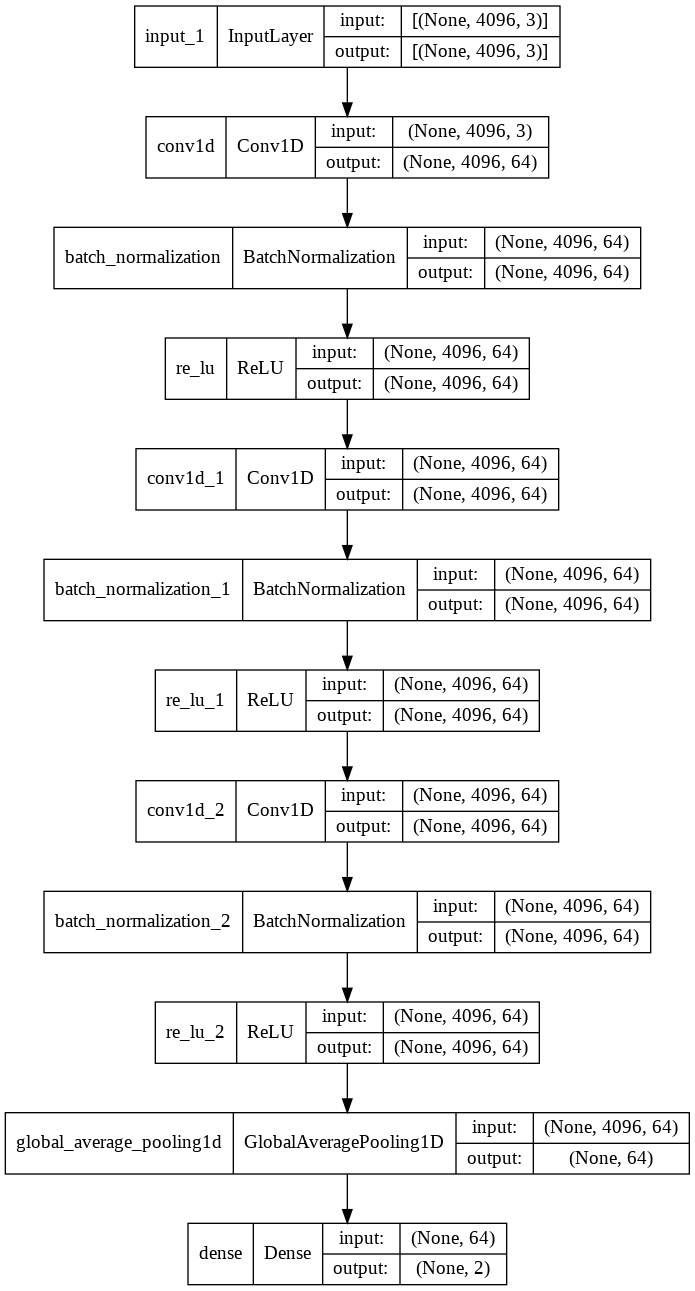

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

tf.keras.backend.clear_session()
with strategy.scope():
  model = make_model(input_shape=(4096,3))
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
!pip install nnaudio

In [ ]:
import pandas as pd
import seaborn as sns
from scipy import signal
# from gwpy.timeseries import TimeSeries.
# from gwpy.plot import Plot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
import random
# from colorama import Fore, Back, Style
# plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

import torch
from nnAudio.Spectrogram import CQT1992v2

In [ ]:
with strategy.scope():
  model_keras_seq = Sequential()
  model_keras_seq.add(Conv1D(64, input_shape=(3, 4096), kernel_size=3, activation='relu'))
  model_keras_seq.add(BatchNormalization())
  model_keras_seq.add(Flatten())
  model_keras_seq.add(Dense(64, activation='relu'))
  model_keras_seq.add(Dense(1, activation='sigmoid'))

  model_keras_seq.compile(optimizer= Adam(lr=2e-4), loss='binary_crossentropy', metrics=['acc'])
  model_keras_seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1, 64)             786496    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 64)            256       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 790,977
Trainable params: 790,849
Non-trainable params: 128
______________________________________________

In [ ]:
hist = model_keras_seq.fit(raw_wave_train_dataset, steps_per_epoch = STEPS_PER_EPOCH, callbacks=[get_lr_callback()], epochs = EPOCHS, verbose = VERBOSE)

# Experimenting with Image Analysis 

In [ ]:
raw_image_dataset = tf.data.TFRecordDataset(TRAINING_FILENAMES[0])

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
imgs = []
targets = []
for image_feature in parsed_image_dataset.take(500):
    height = image_feature['height']
    width = image_feature['width']
    image_raw = image_feature['image_raw']
    image = tf.io.decode_raw(image_feature['image_raw'],tf.float32)
    image = tf.reshape(image, (image_feature['height'], image_feature['width']))

    # Normalise image and apply color map. 
    # image = colorize(image, cmap='viridis')
    # image = cv2.resize(image.numpy(),(224,224))
    # image = tf.image.resize(image,(224,224))
    # image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image *= 255
    image = tf.cast(image,tf.uint8)
    target = tf.cast(image_feature['label'], tf.float32)
    imgs.append(image)
    targets.append(target)
imgs = np.array(imgs)

In [ ]:
signal_images = []
no_signal_images = []
for idx, img in enumerate(imgs):
  if targets[idx] == 0:
    no_signal_images.append(img)
  else:
    signal_images.append(img)

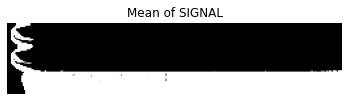

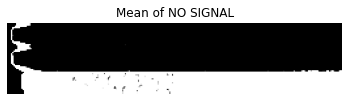

In [ ]:
def find_mean_img(full_mat, title, size = (image_feature['height'], image_feature['width'])):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    mean_img *= 255
    mean_img = tf.cast(mean_img,tf.uint8)
    plt.imshow(mean_img, cmap='Greys_r')
    plt.title(f'Mean of {title}')
    plt.axis('off')
    plt.show()
    return mean_img

signal_mean = find_mean_img(signal_images, 'SIGNAL',)
no_signal_mean = find_mean_img(no_signal_images, 'NO SIGNAL')

# https://gist.github.com/stereopickle/1bce78bcd925f89ef4e33070cfb7e43d#file-pneumonia_mean-py

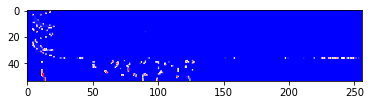

In [ ]:
contrast_mean = no_signal_mean - signal_mean
plt.imshow(contrast_mean,cmap='bwr') 

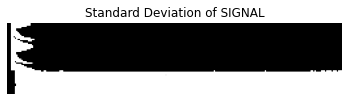

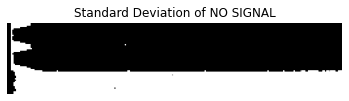

In [ ]:
def find_deviation_img(full_mat, title, size = (image_feature['height'], image_feature['width'])):
    # calculate the average
    deviation_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    deviation_img = deviation_img.reshape(size)
    deviation_img *= 255
    deviation_img = tf.cast(deviation_img,tf.uint8)
    plt.imshow(deviation_img, cmap='Greys_r')
    plt.title(f'Standard Deviation of {title}')
    plt.axis('off')
    plt.show()
    return deviation_img

signal_deviation = find_deviation_img(signal_images, 'SIGNAL',)
no_signal_deviation = find_deviation_img(no_signal_images, 'NO SIGNAL')

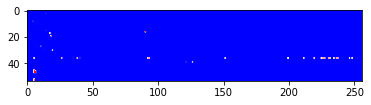

In [ ]:
contrast_deviation = no_signal_deviation - signal_deviation
plt.imshow(contrast_deviation, cmap='bwr') 

In [ ]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (image_feature['height'], image_feature['width'])):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (image_feature['height'], image_feature['width'])):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(signal_images, 'SIGNAL'))
plot_pca(eigenimages(no_signal_images, 'NO SIGNAL'))